In [ ]:
# Use this to zip everything in the content folder.
# Find instructions here on how to update the url path https://medium.com/@acpanjan/download-google-drive-files-using-wget-3c2c025a8b99
!zip -r data.zip .

In [ ]:
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1sSg2qhwL5thi22WKE-C7YqADRonAOdn3' -O data    
# !unzip data -d my_data
# !mv -n my_data/* .

# Top Box Office Films

# Motivation

The dataset we used to conduct our analysis is the set of films that grossed the highest revenue in the US box office for a given weekend from 2001 to 2021. We ultimately chose this dataset because we found it very compelling to see if we can draw any conclusions about what might bring success to a film. Are there certain specific actors, or groups of actors that seem to contribute to a films success to a large degree? Some genres of films are certainly more likely to be successfull than others.

These are the sorts of questions we hope to answer for ourselves, and convey in an effective way to any readers. We hope that the accompanying website serves to provide insight into our analysis and ilicit a desire to examine the anlysis closer. We further hope that this explainer notebook is able to satisfy any user who decides to have a look.

# Data & Basic Statistics

There are a couple of noteworthy points in regards to how we preprocess our data; We are building our dataset by scraping film data from the wiki for top box office films. Something we had to deal with was unpredictable formatting of the relevant sections from which we were attempting to extract data. This meant that there were many erroneous entries in some of our attributes. Here we were faced with a choice of refining our extraction methods by increasing the specificity of the regular expressions we are using to conduct the extractions. Or to manually filter the data after the fact. We ultimately chose the latter as our dataset is not particularly large and it was relatively easy to identify offending entries.

We found it to be the case that most of the film pages we scraped were complete in regards to the attributes we were extracting. This left us with very few incidents of missing data, so much so that we felt comfortable handling entries with missing data attributes by simply dropping them all together.

Our dataset consists of a 713 films, together with associated attributes such as starring actors, genres, and box office revenue. The films are from a list of the top box office film for each weekend from 2001 to 2021.

# Importing modules

In [ ]:
!pip install wptools
!pip install wikipedia-api
!pip install nltk
!pip install python_louvain

     |████████████████████████████████| 227 kB 5.5 MB/s 
  Created wheel for pycurl: filename=pycurl-7.44.1-cp37-cp37m-linux_x86_64.whl size=292990 sha256=0751a8d060247e32720d01677d1ebb497f3b28e6f614c948ce6e5217c76dcaa8
  Stored in directory: /root/.cache/pip/wheels/c5/46/b4/4dc60b406282c22dd4f1ca7da5c949e88aeadb78283123f94d
Successfully built pycurl
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.5.4-py3-none-any.whl size=13475 sha256=3d9fdc946207705e16cedaaacd2e290b595a813e02185016008cecef0ca0372f
  Stored in directory: /root/.cache/pip/wheels/d3/24/56/58ba93cf78be162451144e7a9889603f437976ef1ae7013d04
Successfully built wikipedia-api


In [ ]:
import urllib
import pandas as pd
import json
import wptools
import re
import requests
from bs4 import BeautifulSoup
import os.path
import wikipediaapi
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
import matplotlib.pyplot as plt
import networkx as nx
import ast
import numpy as np
import community
from community import community_louvain
import operator
import itertools
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import random
from PIL import Image
from wordcloud import WordCloud
from fa2 import ForceAtlas2

In [ ]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Data retrieval

### Attaining movie titles and links

In [ ]:
# Function to retrieve a list of movies to use and put it in a csv

def get_movie_titles(url):
    with urllib.request.urlopen(url) as fp:
        mybytes = fp.read()
        page = mybytes.decode("utf8")
    data = BeautifulSoup(page).find_all('table', attrs={'class':'wikitable'})[0]
    titles = list(pd.read_html(str(data))[0].Film)
    titles_and_links = []
    for a in data.find_all('a', href=True):
        try:
            link_title = a.contents[0]
            link_href = a['href']
            if link_title in titles:
                titles_and_links.append((link_title, urllib.parse.unquote(link_href.split("/")[2])))
        except KeyError:
            pass

    return titles_and_links

def fetch_top_box_office_films(start_year, end_year):
    urls = [ f"https://en.wikipedia.org/wiki/List_of_{x}_box_office_number-one_films_in_the_United_States" for x in range(start_year, end_year+1) ]
    for url in urls:
        yield get_movie_titles(url)

dfs = [ df for df in fetch_top_box_office_films(2001, 2021) ]

df2 = [val for sublist in dfs for val in sublist]

data = pd.DataFrame(df2, columns=["title", "link"]).drop_duplicates()

data.to_csv('titles_and_links.csv')

### Attaining wiki sidebar info

For each film we fetch the associated sidebar data that contains all the attributes we are interested in.

In [ ]:
def get_info_box(title):
    return wptools.page(title, silent=True).get_parse().data['infobox']

In [ ]:
 # Function to get info from the sidebar of a wikipedia page

def get_sidebar_info(subject):
    
    subject = subject.replace('.','')

    url = 'https://en.wikipedia.org/w/api.php'
    params = {
                'action':'query',
                'prop':'revisions',
                'format':'json',
                'rvprop':'content',
                'titles':subject,
                'rvsection':0,
            }
    data = requests.get(url, params=params).json()
    page_id = list(data['query']['pages'].keys())[0]
    
    result = data['query']['pages'][page_id]['revisions'][0]['*']
    
    if result[1:9] == 'REDIRECT' or result[1:9] == 'redirect':
        print(result)
        pat = '\[\[([\w\s\'\.\,\d\(\)\:]+)\]\]'
        match = re.findall(pat,result)
        params['titles'] = match[0]
        data = requests.get(url, params=params).json()
        page_id = list(data['query']['pages'].keys())[0]
        return data['query']['pages'][page_id]['revisions'][0]['*']
    else:
        return result

In [ ]:
# Loading the list of movies to be used for analysis.

new_movies = pd.read_csv("titles_and_links.csv")

In [ ]:
# Getting a dictionary of movie info from the sidebar.
# WARNING: 10 minute+ runtime on this cell

sidebar_info = {}
used_movies = []
unused_movies = []
for movie in new_movies['link']:
    try:
        sidebar_info[movie] = get_info_box(movie)
        used_movies.append(movie)
    except LookupError as e:
        print(f"Couldn't get sidebar info for {movie}.\nException: ", e)
        unused_movies.append(movie)
with open("movie_data.json", "w") as f:
   f.write(json.dumps(sidebar_info))

API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


Couldn't get sidebar info for Fahrenheit_9.
Exception:  https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Fahrenheit_9


The following functions are used to collect the relevant attributes from the films sidebar content.

In [ ]:
# This is used to clean actor data. The list contains many of the strings that were hard to catch with regular expressions. These strings are a part of Wikipedia management.

actor_intruders= ['Pleasedonotaddalinkhere.ItisanOVERLINKasRuddiscreditedasawriterandlinkedabove.Thankyou',
    'OVERLINK.Ruddislinkedearlierintheinfoboxforhiswritingcredit',
    'starringparametershouldbepropagatedwithcreditsfromthebillingblockofthetheatricalposter',
    'DONOTCHANGETHISCAST',
    'THISISACCORDINGTOTHECREDITBLOCKONTHEPOSTER',
    'Itisaccordingtothebillingatthebottomoftheposter',
    'PERPOSTERBILLING',
    'Perofficialposterbillingblock',
    'November2021',
    'name',
    'publisher',
    'title',
    'url',
    'work',
    'BareURLinline',
    'endcreditsandthisdiscussiononthetalkpage',
    'access',
    'archive',
    'Talk',
    'PERPOSTERBILLINGBLOCK',
    'ParamountPictures',
    'Orderperthemainon',
    'February13',
    'February14',
    'whichappearstobe',
    'postercreditsorderisMcAvoy',
    'instructions',
    'andFey.',
    'PERBILLINGBLOCKONPOSTER',
    'withMackieaddedperhisplacementinthefilmandbasedontalkpagediscussions',
    'Starringlistisbasedonthefilmposter',
    'THISISACCORDINGTOTHECREDITBLOCKONTHEPOSTER',
    'DONOTchangeorderperposterbillingblock',
    'Despitenotappearingonofficialposters',
    'Unbulletedlist',
    'DONOTADDANYONEELSE.ONLYSTAR',
    'Plassedoesnotappearonpostersopleasedonotaddhim',
    'Orderperthefilm',
    'andshouldnotbechangedwithoutdiscussion',
    'SCREENCREDITINCREDITS',
    'Perbillingblock',
    'Peropeningcredits',
    'UnitedStatesNavySEALs',
    'U.S.NavySEALs',
    'Onlypeoplecreditedonthepostergointheinfobox',
    'PERBILLINGBLOCK.DONOTCHANGE.',
    'DONOTADDANYMORENAMES',
    'DONOTADDANYONEELSE',
    'DONOTADDANYONEELSE.ONLYSTAR',
    'CREDITSPERhttp',
    'CASTLISTTAKENDIRECTLYFROMPOSTER.PLEASEDISCUSSONTALKPAGEBEFORECHANGING.',
    'BrienandScodelariogetthetopbillingwithClarksongettingthelastbilling',
    'SCREENCREDITINCREDITS',
    'Castorderisbasedonthecreditsbillingblockonposterhttp',
    'Castlistisperfeaturednamesontheposter',
    'Orderbasedontitlecreditspertalkpageconsensus',
    'Orderbasedonbillingblock',
    'SEETALKPAGE',
    'STARRINGCREDITSPERFILMPOSTER',
    'November2021',
    'Perposterblock',
    'PERBILLINGBLOCK.',
    'Perposterbillingblock',
    'PERCREDITSORDER',
    'perposterblock.PleasedonotaddSteveCarellwhosenamedoesn',
    'PERPOSTERBLOCKONLYTHESEFOURACTORSNAMESAPPEAR',
    'DonotaddlinkhereperWP',
    'PLEASEDONOTCHANGETHISCAST',
    'PERBILLINGPOSTER.PLEASEDISCUSSONTALKPAGEBEFORECHANGING.',
    'Onlypeoplecreditedonthepostergointheinfobox',
    'PERBILLINGBLOCK.DONOTCHANGE.',
    'Theactorslistedherearethoselistedinthebillingblockoftheposter.Pleasedonotlistanyoneelseorchangetheorder.Thankyou.',
    'DONOTCHANGE.PEROFFICIALBILLINGBLOCK',
    'withMackieaddedperhisplacementinthefilmandbasedontalkpagediscussions.',
    'DONOTREMOVE',
    'asheisnotcreditedinthemaincast',
    'limitedtothoseappearingonthefilm',
    'born1969',
    'perbillingincredits',
    'plainlist',
    'pleasedonotlistanyoneelse.Thankyou.',
    'pleasedonotchange',
    'Thesearetheactorsaslistedonthefilm',
    'Thecastisinorder',
    'Thisisaccordingtotheendcreditsbilling',
    'born1972',
    'perposter',
    'FORFURTHERINFORMATION',
    'GENDERIDandconsistentwithJunoandFreeheldarticles',
    'FILMCASTPERLOCALCONSENSUS.PLEASESEETALKPAGE',
    'RAYNOTTHEPOSTERAGAINSTWP',
    'Perbillingblockascreditedonofficialwebsitehttps',
    'PleasedoNOTlinktoPaulRuddperWP',
    'Pleasedonotaddalinkhere.ItisanOVERLINKasRuddiscreditedasawriterandlinkedabove.Thankyou',
    'Perendcredits',
    'sothere',
    'tthatlong',
    'whichisn',
    'PERPOSTER']

In [ ]:
def get_actors(text):
    keywords = ['starring']
    for word in keywords:
        if word in list(text.keys()):
            cut_out = text[word]
            break
    pat = r'[\w\s\.]+'
    try:
        pre_final = re.findall(pat,cut_out)
    except:
        return None

    final = [ match for match in pre_final if " " in match and match[-1] is not " " ] 


    # Cleaning
    cleaning_cases = ['\n', ' ']
    for index, instance in enumerate(final):
        for c_case in cleaning_cases:
            final[index] = final[index].replace(c_case, '')

    strings_to_remove = ['Perposterbilling', 'Plainlist', 'Thisorderisaccordingtothefilm','PERBILLINGBLOCK','']
    strings_to_remove = actor_intruders
    for instance in strings_to_remove:
        while instance in final: final.remove(instance)  
    
    for intruder in actor_intruders:
        if intruder in final:
            final.remove(intruder)

    return list(set(final))

In [ ]:
def get_director(text):
    keywords = ['director']
    for word in keywords:
        if word in list(text.keys()):
            cut_out = text[word]
            break
    pat = r'[\w\s\.]+'
    try:
        pre_final = re.findall(pat,cut_out)

    except Exception as e:
        print(e)
        return None

    final = [ match for match in pre_final if " " in match and match[-1] is not " " ] 

    # Cleaning
    cleaning_cases = ['\n']
    for index, instance in enumerate(final):
        for c_case in cleaning_cases:
            final[index] = final[index].replace(c_case, '')

    return final

In [ ]:
def get_producer(text):

    keywords = ['producer', 'produced_by', 'producers']
    for word in keywords:
        if word in list(text.keys()):
            cut_out = text[word]
            break

    pat = r'[\w\s\.\"]+'
    try:
        pre_final = re.findall(pat,cut_out)
    except:
        return None

    final = [ match for match in pre_final if " " in match and match[-1] is not " " ] 

    # Cleaning
    cleaning_cases = ['\n']
    for index, instance in enumerate(final):
        for c_case in cleaning_cases:
            final[index] = final[index].replace(c_case, '')

    return final

In [ ]:
def get_writer(text):
    keywords = ['writer', 'based_on', 'screenplay', 'writers']
    for word in keywords:
        if word in list(text.keys()):
            cut_out = text[word]
            break
    pat = r'[\w\s\.]+'
    try:
        pre_final = re.findall(pat,cut_out)
    except:
        return None

    final = [ match for match in pre_final if " " in match and match[-1] is not " " ] 

    # Cleaning
    cleaning_cases = ['\n']
    for index, instance in enumerate(final):
        for c_case in cleaning_cases:
            final[index] = final[index].replace(c_case, '')


    return final

In [ ]:
def get_box_office(text):
    keywords = ['box_office', 'gross']
    for word in keywords:
        if word in list(text.keys()):
            cut_out = text[word]
            break
    pat = r'[\d\.]+'

    try:
        value = re.findall(pat,cut_out)
    except:
        return 0

    pat2 = r'million'
    pat3 = r'billion'
    mil_search = re.findall(pat2,cut_out)
    bil_search = re.findall(pat3,cut_out)

    try:
        value = float(value[0])
        if bil_search:
            value = value * 1000
        return value * 1000000
    except Exception as e:
        #print(e)
        return 0

In [ ]:
df = pd.read_csv("titles_and_links.csv").iloc[:, 1:]

with open("movie_data.json", "r") as f:
    data = json.load(f)

sidebar_info = {}
used_movies = []
for movie in df["link"]:
    try:
        sidebar_info[movie] = data[movie]
        used_movies.append(movie)
    except KeyError as e:
        print(f"couldn't get sidebar info for {e}")

couldn't get sidebar info for 'Fahrenheit_9'


Here we add actors, directors, producers, writers, and box office attributes to our dataset.

In [ ]:
df['actors'] = None
df['directors'] = None
df['producers'] = None
df['writers'] = None
df['box_office'] = 0

for movie in used_movies:
    text = sidebar_info[movie]
    try:
        df.loc[df['link'] == movie,'actors'] = str(get_actors(text))
        df.loc[df['link'] == movie,'directors'] = str(get_director(text))
        df.loc[df['link'] == movie,'producers'] = str(get_producer(text))
        df.loc[df['link'] == movie,'writers'] = str(get_writer(text))
        df.loc[df['link'] == movie,'box_office'] = float(get_box_office(text))

    except Exception as e:
        print(movie, e)

local variable 'cut_out' referenced before assignment
local variable 'cut_out' referenced before assignment


Here we categorize films into 5 different box office catergories.

In [ ]:
box_office_values = np.sort(df['box_office'].values)

groups = []
for value in (df['box_office']):
    if value < np.percentile(box_office_values, 20):
        groups.append('very low box office')
    if np.percentile(box_office_values, 40) > value >= np.percentile(box_office_values, 20):
        groups.append('low box office')
    if np.percentile(box_office_values, 60) > value >= np.percentile(box_office_values, 40):
        groups.append('medium box office')
    if np.percentile(box_office_values, 80) > value >= np.percentile(box_office_values, 60):
        groups.append('high box office')
    elif value >= np.percentile(box_office_values, 80):
        groups.append('very high box office')
    
df['bo_groups'] = groups

### Attaining movie plots from the Wikipedia API

For our text analysis we will be using the plot descriptions of the movies. Plot descriptions can be found in the *Plot, Summary or Premise* section of their wikipedia page. We save each extracted movie plot in a document. All movie plot documents can be found in the *plots* folder.



In [ ]:
!mkdir 'plots'

mkdir: cannot create directory ‘plots’: File exists


In [ ]:
# Fetch movie plots from Wikipedia - Save each plot in a document
movies_without_plot = []
for page in df['link']:
    
    try:
        fname = 'plots/' + page + '.txt'
        if(os.path.isfile(fname) == False):
    
            wikiPage = wikipediaapi.Wikipedia('en').page(page)
            sections = wikiPage.sections

            # 1. search 'Plot' section
            plot_section = next((section for section in sections if section.title == "Plot"), None)

            # 2. search 'Summary' section
            if plot_section is None:
                plot_section = next((section for section in sections if section.title == "Summary"), None)

            # 3. search 'Premise' section
            if plot_section is None:
                plot_section = next((section for section in sections if section.title == "Premise"), None)

            if plot_section:
                plotWikiText = plot_section.text

            # collect movies without a 'Plot/Summary/Premise' section
            if plot_section is None:
                print("No plot found", page)
                movies_without_plot.append(page)
            else:
                #save plot text in file
                with open( 'plots/' + page + '.txt', 'w') as f:
                    f.write(plotWikiText)
    except Exception as e: 
        print("Failed to get plot", page)
        print(e)
        movies_without_plot.append(page)

No plot found Fahrenheit_9
No plot found Hannah_Montana_and_Miley_Cyrus:_Best_of_Both_Worlds_Concert
No plot found Hotel_Transylvania


### Preprocessing Plot Text

After getting each movie plot and saving it, we applied the following data cleaning steps:
1. Header removal using the regex pattern r"\=(=)+(.*?)\=(=)+"
2. Tokenized text and removed punctuation using RegexpTokenizer(r'\w+')
3. Normalized tokens by setting everything to lowercase
4. Removed stopwords
5. Removed one-letter and two-letter words
6. Lematized tokens using WordNetLemmatizer()

In [ ]:
!mkdir 'plot_tokens'

mkdir: cannot create directory ‘plot_tokens’: File exists


In [ ]:
# clean plots and tokenize
plots_path = "./plots/"
header_pattern = r"\=(=)+(.*?)\=(=)+"

for movie in df['link']:
    
    try:
        pagePath = plots_path+movie+".txt"

        with open(pagePath, "r") as f:
            movie_plot = f.read()

        # remove headers
        movie_plot = re.sub(header_pattern, '', movie_plot)   

        # tokenize & remove punctuation
        tokens = RegexpTokenizer(r'\w+').tokenize(movie_plot)

        # normalize: set everything to lowercase
        words = [w.lower() for w in tokens]

        # remove stopwords
        words = [word for word in words if word not in stopwords.words('english')]

        # remove one-letter and two-letter words
        words = [word for word in words if len(word) > 2]

        #lemmatize
        wnl = WordNetLemmatizer()
        lemmatized_words = []
        for word, tag in pos_tag(words):
            wntag = tag[0].lower()
            wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
            if not wntag:
                lemma = word
            else:
                lemma = wnl.lemmatize(word, wntag)
            
            lemmatized_words.append(lemma)

        #save plot words in file
        filename = 'plot_tokens/' + movie + '.txt'
        with open(filename, 'w') as f:
            json.dump(lemmatized_words, f)
    except Exception as e: 
        print(e)

[Errno 2] No such file or directory: './plots/Fahrenheit_9.txt'
[Errno 2] No such file or directory: './plots/Hannah_Montana_and_Miley_Cyrus:_Best_of_Both_Worlds_Concert.txt'
[Errno 2] No such file or directory: './plots/Hotel_Transylvania.txt'


In [ ]:
# add plots and tokens in our dataset
# add movie plot words to dataframe

plots = []
word_lists = []
unique_terms_lists = []

for index, row in df.iterrows():
    pagePath = "./plot_tokens/"+row['link']+".txt"
    pagePath_plot = "./plots/"+row['link']+".txt"
    
    try:
        with open(pagePath, "r") as f:
            text = f.read()
            words = RegexpTokenizer(r'\w+').tokenize(text)
            word_lists.append(sorted(words))

            # remove duplicates
            unique_terms = sorted(set(words))
            unique_terms_lists.append(unique_terms)
        with open(pagePath_plot, "r") as f:
            text = f.read()
            plots.append(text)
    except:
        # handle movies without a plot
        words = []
        word_lists.append(sorted(words))
        
        unique_terms = []
        unique_terms_lists.append(unique_terms)
        
        plot = []
        plots.append(plot)

df["Plot"] = plots
df["Tokens"] = word_lists
df["Unique_Tokens"] = unique_terms_lists

### Attaining movie genres from the IMDB API

We are interested in grouping movies by their genre. Since Wikipedia infobox did not include genres, we extract them by using the **IMDB API** :

1. Start by searching IMDB for a movie title.
2. Fetch results and get the top one returned.
3. Search IMDB by that result's id
4. Fetch movie details
5. Extract *genres* attribute

In [ ]:
apiKey = "k_oa84g201"
baseurl = "https://imdb-api.com/en/API/"

In [ ]:
# search movie by title
def search_imdb_movie(apiKey, title):
    
    query = baseurl + "SearchTitle/" + apiKey + "/" + title

    response = requests.get(query)
    movie = response.json()

    return movie

In [ ]:
# search movie by imdb movie id
def get_imdb_movie(apiKey, id):
    
    query = baseurl + "Title/" + apiKey + "/" + id

    response = requests.get(query)
    movie = response.json()
        
    return movie

In [ ]:
# WARNING: 10 minute+ runtime on this cell
no_genre_movies = []
all_movie_genres = []

  
index = 0
for title in df["title"]:
    try:
        # search imdb by title - get top result
        result = search_imdb_movie(apiKey, title)['results'][0]
        movie_id = result['id']
        movie_title = result['title']
        
        # search imdb by movie id - get genres
        movie_info = get_imdb_movie(apiKey, movie_id)
        movie_genres = movie_info['genres'].split(",")
        all_movie_genres.append(movie_genres)
        index +=1
    except Exception as e:
        print(e)
        print(index, ": Could not fetch: ", title)
        all_movie_genres.append([])
        no_genre_movies.append(title)
        index +=1

In [ ]:
no_genre_movies

['Cats & Dogs', 'Fahrenheit 9/11']

In [ ]:
# add genres to dataset
df['genres'] = all_movie_genres

### Combine movie plots with genres

Since we will, later on, need to make a text analysis for each genre, we need to create a document of plots for each genre by:
1.  Getting the unique genre values found in our dataset
2.  Finding the movies that belong to each unique genre
3.  Combining their processed plot tokens into a single document
4.  Combining all documents into a csv for later use


In [ ]:
genres = [item for sublist in df.genres.tolist() for item in sublist]
genres = [x.strip(" ") for x in genres]
unique_genres = set(genres)

# remove no genre
unique_genres = list(filter(None, unique_genres))

In [ ]:
!mkdir 'genre_tokens'

In [ ]:
# create and save one document per genre
for genre in unique_genres:
    document = []
    for index, row in df.iterrows():
        movie_genres = [x.strip(" ") for x in row.genres]
        if genre in movie_genres:
            document = document + row.Tokens

    #save genre tokens in file
    document = sorted(w for w in document)
    filename = 'genre_tokens/' + genre + '.txt'
    with open(filename, 'w') as f:
        json.dump(document, f)

In [ ]:
df_genre = pd.DataFrame({'Genre': unique_genres}) 

In [ ]:
# add genre words to a dataframe
token_lists = []
unique_token_lists = []
plots = []

for genre in unique_genres:
    charPagePath = "./genre_tokens/"+genre+".txt"
    
    with open(charPagePath, "r") as f:
        text = f.read()
        tokens = RegexpTokenizer(r'\w+').tokenize(text)
        token_lists.append(sorted(tokens))

        # remove duplicates
        unique_tokens = sorted(set(tokens))
        unique_token_lists.append(unique_tokens)

In [ ]:
# combine plots foreach genre
genre_plots = []
for genre in unique_genres:
    document = ""
    for index, row in df.iterrows():
        movie_genres = [x.strip(" ") for x in row.genres]
        if genre in movie_genres:
            document = document + str(row.Plot)
    genre_plots.append(document)

In [ ]:
df_genre['Tokens'] = token_lists
df_genre['Unique_Tokens'] = unique_token_lists
df_genre['Plot'] = genre_plots

In [ ]:
df_genre.to_csv("tokens_per_genre.csv")

# Basic Stats

### Genre statistics

**Which genres does our dataset have?**

In [ ]:
unique_genres

['Documentary',
 'Drama',
 'Western',
 'Adventure',
 'Music',
 'Crime',
 'Animation',
 'Comedy',
 'Sport',
 'Musical',
 'History',
 'Thriller',
 'Biography',
 'Action',
 'Horror',
 'Mystery',
 'Romance',
 'Family',
 'Sci-Fi',
 'Fantasy',
 'War']

In [ ]:
# find how many movies each genre has
default_value = 0 
genre_dict = dict.fromkeys(unique_genres, default_value)

for genre in unique_genres:
    for index, row in df.iterrows():
        movie_genres = [x.strip(" ") for x in row.genres]
        if genre in movie_genres:
            genre_dict[genre] +=1

**Which are the most popular genres?**

In [ ]:
genre_dict = {k: v for k, v in sorted(genre_dict.items(), key=lambda item: item[1], reverse=True)}

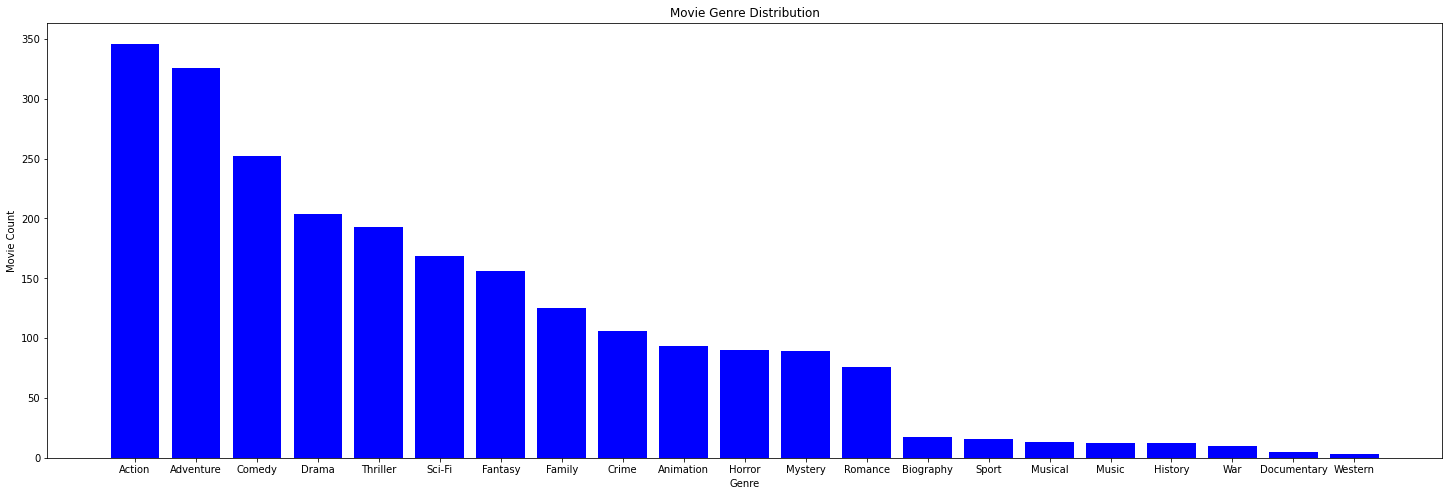

In [ ]:
plt.figure(figsize=(25,8))
plt.bar(genre_dict.keys(), genre_dict.values(), color='b')
plt.xticks(list(genre_dict.keys()))
plt.xlabel("Genre")
plt.ylabel("Movie Count")
plt.title("Movie Genre Distribution")
plt.show()

In [ ]:
df.to_csv('data.csv')

# Tools, theory and analysis

Our analysis includes three major parts.


For the data processing and retrieval we mainly utilized API's and regular expressions. 

In network analysis we had a big focus on degree distribution. We examined it based on different attributes. The findings were visualized and discussed. Besides that, we examined the statistics of our networks like the clusterring coefficient, assortativity and several others. These were used to gain a better understanding of our network and perhaps find some patterns or anomalies.

A big part of our work was text analysis. We worked with TF-IDF and VADER. We examined the movie plot description from wikipedia. The top words were extracted and the sentiment values for every movie. We were searching for patterns related to the success/profit of the films.


**Additional information on analysis**

The movies were assigned to one of the groups (very low box office, low box office, medium box office, high box office, very high box office). This was done by exctracting some thresholds from the sorted list of all box office values. We picked the 20th, 40th, 60th and the 80th percentiles for this.

The genres were also used in a similar fashion. They were used as attributes for various investigations.

## Step 1: Building the network



### Loading data and building starter network

In [ ]:
df = pd.read_csv('data_final.csv')

In [ ]:
df = df.replace('[]', np.nan)
df = df.replace('None', np.nan)
df = df.dropna()

In [ ]:
#Create dictionary, where the keys are movies and the values are the actors starring in them.
movie_connections = {}

#Iterate through the dataframe and find the data.
for index, row in df.iterrows():
    movie_connections[row.title] = ast.literal_eval(row.actors)

In [ ]:
#Create a network where the nodes are movies and they are connected if they share actors starring in them.
#Each node has three attributes:box office group, genres and community number.
#The retrieval of the values for the attributes is a bit tricky, so some processing is needed.

H_movies_starter = nx.Graph()

for movie in movie_connections:
    movie_info = df[df.title == movie]

    H_movies_starter.add_node(movie)
    for another_movie in movie_connections:
        if another_movie not in H_movies_starter:
            another_movie_info = df[df.title == another_movie]

            H_movies_starter.add_node(another_movie)
        if not H_movies_starter.has_edge(movie, another_movie) and movie != another_movie:
            for actor in movie_connections[movie]:
                if actor in movie_connections[another_movie]:
                    H_movies_starter.add_edge(movie, another_movie)

In [ ]:
# Number of edges/nodes in the movie network
print("The Movie network has:",H_movies_starter.number_of_edges(), " edges")
print("The Movie network has:",H_movies_starter.number_of_nodes(), "nodes")

The Movie network has: 7355  edges
The Movie network has: 713 nodes


### Detect movie communities and add them to dataset

In [ ]:
# compute the best partition based on the louvain algorithm
partition = community_louvain.best_partition(H_movies_starter)

In [ ]:
# Group partition dictionary by number of community
communities = {}
for key, value in sorted(partition.items()):
    communities.setdefault(value, []).append(key)

print("There are", len(communities), "communities")

There are 25 communities


In [ ]:
# Add communities to dataset
movie_community = []
for index, row in df.iterrows():
  com_num = [k for k, v in communities.items() if row.title in v][0]
  movie_community.append(com_num)

df['community'] = movie_community

In [ ]:
df.iloc[: , 1:].to_csv("data_final.csv")

### Build Final Networks

In [ ]:
df = pd.read_csv('data_final.csv')

#### Movie Network

In [ ]:
#Create dictionary, where the keys are movies and the values are the actors starring in them.
movie_connections = {}

#Iterate through the dataframe and find the data.
for index, row in df.iterrows():
    movie_connections[row.title] = ast.literal_eval(row.actors)

In [ ]:
#Create a network where the nodes are movies and they are connected if they share actors starring in them.
#Each node has three attributes:box office group, genres and community number.
#The retrieval of the values for the attributes is a bit tricky, so some processing is needed.

H_movies = nx.Graph()

for movie in movie_connections:
    movie_info = df[df.title == movie]
    genres = ast.literal_eval(movie_info.genres.values[0])
    genres_clean = []
    for genre in genres:
        genres_clean.append(genre.replace(' ',''))


    bo = movie_info.bo_groups.values[0]
    com = movie_info.community.values[0]
    H_movies.add_node(movie, bo_group = bo, genre = genres_clean, community = com)
    for another_movie in movie_connections:
        if another_movie not in H_movies:
            another_movie_info = df[df.title == another_movie]
            genres = ast.literal_eval(another_movie_info.genres.values[0])
            genres_clean = []
            for genre in genres:
                genres_clean.append(genre.replace(' ',''))
            
            bo = another_movie_info.bo_groups.values[0]
            com = another_movie_info.community.values[0]
            H_movies.add_node(another_movie, bo_group = bo, genre = genres_clean, community = com)
        if not H_movies.has_edge(movie, another_movie) and movie != another_movie:
            for actor in movie_connections[movie]:
                if actor in movie_connections[another_movie]:
                    H_movies.add_edge(movie, another_movie)

In [ ]:
# Number of edges/nodes in the movie network
print("The Movie network has:",H_movies.number_of_edges(), " edges")
print("The Movie network has:",H_movies.number_of_nodes(), "nodes")

The Movie network has: 7355  edges
The Movie network has: 713 nodes


#### Actor Network

In [ ]:
#Create dictionary, where the keys are actors and the values are their connections
actor_connections = {}

#Iterate through the dataframe and work with each movie
for index, row in df.iterrows():
    
    #convertng str to list of str
    temp_list = ast.literal_eval(row.actors)

    #Here for each actor in a movie a connection is created to the other actors
    for i,actor in enumerate(temp_list):
        actor_connections[actor] = []
        for j,another_actor in enumerate(temp_list):
            if another_actor not in actor_connections[actor] and actor != another_actor:
                actor_connections[actor].append(another_actor)

In [ ]:
#Here the actual network is created using the dictionary from before. Some if statements are used to avoid duplicates.

G_actors = nx.Graph()

for actor in actor_connections:
    G_actors.add_node(actor)
    for another_actor in actor_connections[actor]:
        if another_actor not in G_actors:
            G_actors.add_node(another_actor)
        if not G_actors.has_edge(actor, another_actor):
            G_actors.add_edge(actor, another_actor)

In [ ]:
# Number of edges/nodes in the actor network
print("The Actor network has:",G_actors.number_of_edges(), " edges")
print("The Actor network has:",G_actors.number_of_nodes(), "nodes")

The Actor network has: 13113  edges
The Actor network has: 2372 nodes


## Step 2: Network Analysis

### Degree Distributions

In [ ]:
#Getting the degree for each node.

degree_distribution = []
for n in G_actors.nodes():
    degree_distribution.append([G_actors.degree(n),n])

# The list is sorted. So max/min values can be seen.
print(sorted(degree_distribution))

[[0, 'ClintEastwood'], [1, 'ChaneyKley'], [1, 'EmmaCaulfield'], [1, 'IsraelBroussard'], [1, 'JessicaRothe'], [1, 'MicahSloat'], [1, 'RayWise'], [1, 'RobBrown'], [2, 'AsiaArgento'], [2, 'BettyBuckley'], [2, 'BobbyCampo'], [2, 'ChandlerCanterbury'], [2, 'ChristianKane'], [2, 'HelenHunt'], [2, 'IzabellaScorupco'], [2, 'JadenSmith'], [2, 'JonasBloquet'], [2, 'LeonardoDiCaprio'], [2, 'MykeltiWilliamson'], [2, 'PamelaAnderson'], [2, 'PeterSallis'], [2, 'RaymondCruz'], [2, 'ShantelVanSanten'], [2, 'TaissaFarmiga'], [3, 'AdelaideKane'], [3, 'AlanArkin'], [3, 'AlekseySerebryakov'], [3, 'AlexanderGould'], [3, 'AzhyRobertson'], [3, 'BarryWatson'], [3, 'BobPeterson'], [3, 'BrianBoland'], [3, 'BrianGeraghty'], [3, 'CallumKeithRennie'], [3, 'CamillaBelle'], [3, 'CharlieTahan'], [3, 'CharlieYeung'], [3, 'ChristineTaylor'], [3, 'ChristopherLloyd'], [3, 'ClaireDanes'], [3, 'CléBennett'], [3, 'DanielZovatto'], [3, 'DashMihok'], [3, 'DavidMorse'], [3, 'DylanMcDermott'], [3, 'EdAsner'], [3, 'EileenBrennan

In [ ]:
fig = go.Figure()

degree_distribution = [G_actors.degree(n) for n in G_actors.nodes()]
hist, bins = np.histogram(degree_distribution, bins = np.arange(max(degree_distribution)+1))
fig.add_trace(go.Bar(x=bins[:-1], y=hist))
fig.update_layout(title_text='Degree distribution of the actor network',xaxis_title="Node degree",yaxis_title="Frequency")
fig.show()

The most frequently occuring degree value for the actor network is **7**. This value makes a lot of sense. On average there are **7-8** seven actors listed on a movie's wikipedia page, so every actor is connected to their cast member producing the specific number of edges. It can be noted, that many of the degree values are between **5** and **10**. So usually an actor has that many colleagues/fellow actors he/she acts in movies with. Of course, this is highly biased because of several reasons. Our dataset is quite small, we only look at very profitable movies and not all of the actors that acted in the movie are extracted.

5 actors with the most connections:
* Samuel L. Jackson
* Idris Elba
* Dwayne Johnson
* Tyler Perry
* Kevin Hart

5 actors with the least connections:
* Clint Eastwood
* Chaney Kley
* Emma Caulfield
* Israel Broussard
* Jessica Rothe

Regarding, the lists. It could be expected that Samuel L. Jackson would be one of the most connected actors. He is known for his good acting and his uniqueness. He appeared in many Marvel movies and films directed by Quentin Tarantino. This fact alone makes the actor very well known. Dwayne Johnson could also be expected to appear in such a list. He's been very active the past years appearing in many 'Casual' movies.

What is suprising is Clint Eastwood appearing as an actor with the top5 least connections. He is a legend is widely known for his famous roles. However, even though he is still quite involved in workng with cinema his prime years are long gone. Now Clint Eastwood carefully chooses his projects appearing in movies every few years or so.

In [ ]:
#Here we get the degree for each of the node in the movie network

degree_distribution = []
for n in H_movies.nodes():
    degree_distribution.append([H_movies.degree(n),n])

#The values are sorted so min/max values can be seen.
print(sorted(degree_distribution))

[[0, 'Boogeyman'], [0, 'Come Play'], [0, 'Darkness Falls'], [0, 'Friday the 13th'], [0, 'Gran Torino'], [0, 'Happy Death Day'], [0, 'Jigsaw'], [0, 'Paranormal Activity 3'], [0, 'Queen of the Damned'], [0, 'The Devil Inside'], [0, 'The Final Destination'], [0, 'The Roommate'], [0, 'War Room'], [1, 'Act of Valor'], [1, 'Freddy vs. Jason'], [1, 'Hannah Montana: The Movie'], [1, 'It'], [1, 'Jeepers Creepers 2'], [1, 'Ouija'], [1, 'Swimfan'], [1, 'Texas Chainsaw 3D'], [1, 'The Passion of the Christ'], [2, 'Candyman'], [2, 'Chronicle'], [2, 'Good Boys'], [2, 'Jeepers Creepers'], [2, 'Meet the Spartans'], [2, 'Paranormal Activity'], [2, 'Paranormal Activity 2'], [2, 'The Chronicles of Narnia: Prince Caspian'], [2, 'The Invisible Man'], [2, 'The Nun'], [2, 'Up'], [3, 'A Quiet Place'], [3, 'Abominable'], [3, 'Diary of a Wimpy Kid: Rodrick Rules'], [3, 'District 9'], [3, "Don't Breathe"], [3, 'Evil Dead'], [3, 'Fifty Shades Freed'], [3, 'Fifty Shades of Grey'], [3, 'Jurassic Park III'], [3, 'Old

In [ ]:
fig = go.Figure()

degree_distribution = [H_movies.degree(n) for n in H_movies.nodes()]
hist, bins = np.histogram(degree_distribution, bins = np.arange(max(degree_distribution)+1))
fig.add_trace(go.Bar(x=bins[:-1], y=hist))
fig.update_layout(title_text='Degree distribution of the movie network',xaxis_title="Node degree",yaxis_title="Frequency")
fig.show()

The degree distribution illustrates how movies are sharing actors among them. No single value stands out. We could say that **3-30** are the most frequently occuring degree values. More specifically, **21,17** and **23** are the top 3 degree values. In a way this could mean that some actors are not favored when choosing the cast for a movie or that movies are quite diverse with how they choose the movie cast.

The 5 movies with the most connections / actors that are heavily casted for other movies as well:
* Avengers: Age of Ultron
* The Other Guys
* Avengers: Endgame
* Avengers: Infinity War
* The Avengers

The 5 movies with the least connections / actors that are rarely selected for oher movies:
* Boogeyman
* Come Play
* Darkness Falls
* Friday the 13th
* Gran Torino

So it can be seen that Marvel studios chose widely casted actors or made their cast members a very popular option for others. Marvel are making big budget movies, producing huge amounts of revenue, so it makes sense they are also choosing the popular/good actors. The Other Guys is also coming in strong. This movie has actors like Will Ferell, Mark Wahlberg, Dwayne Johnson and Samuel L. Jackson. These are huge names in the industry. We saw Samuel L. Jackson and Dwanye Johnson in the top 5 of the actor's network degree distribution.

For the movies with the least connections we see some interesting things. 4 out of 5 of the listed movies are horror movies, which is quite interesting. This means that horror movies might cast less known actors. We can also see Gran Torino appearing in the list. This is the movie from Clint Eastwood, where he was the director and the main actor. We saw before that Clint Eastwood had 0 connections in the actor's network.

In [ ]:
#We specify the possible values for the box office group. This way we have the nice to view ordering.
box_office_groups = ['very low box office','low box office','medium box office','high box office','very high box office']


#We make a figure of man subplots to visualise the degree distribution for every box office group.
fig = make_subplots(rows=5, cols=1, shared_xaxes=True, shared_yaxes=True)

for i,group in enumerate(box_office_groups):
    degree_distribution = []
    for n in H_movies.nodes():
        if H_movies.nodes[n]['bo_group'] == group:
            degree_distribution.append(H_movies.degree(n))


    hist, bins = np.histogram(degree_distribution, bins = np.arange(max(degree_distribution)+1))
    fig.add_trace(go.Bar(x=bins[:-1], y=hist,name=group),i+1,1)

fig.update_xaxes(title_text="Degree", row = 5, col = 1)
fig.update_yaxes(title_text="Frequency", row = 4, col = 1)
fig.update_layout(title_text="Degree distributions of the movie network for different box office ranges")
fig.show()

Above we have the degree distributions for the movie network. They are categorized with respect to their box office values. A trend is seen where the movies with higher box office values have more widely used cast and movies with lower box office values have actors that are less used. This relationship makes sense. A popular/widely casted actor can be casted for his/her skills but also for their marketing value. An actor like Dwanye Johnson is probably quite aware of his value as a marketing asset and he definetely utilizes that.

In [ ]:
#This is used to extract the possible genres. Then some genres are removes from the list because they contain few movies.

temp=list(set(df['genres'].values))

movie_genres = [value for sublist in temp for value in ast.literal_eval(sublist)]

movie_genres_set = list(set(movie_genres))

genre_list = []
for genre in movie_genres_set:
    genre_list.append(genre.replace(' ',''))

genre_list = np.sort(list(set(genre_list)))

genre_list = list(genre_list)

small_genres = ['War','Sport','History','Biography','Music','Musical','Western','Documentary']

for genre in small_genres:
    genre_list.remove(genre)

In [ ]:
# Degree distribution for every genre is made. Well, for every genre that contains a relatively large amount of movies. The previously made list is used.

fig = make_subplots(rows=10, cols=2, shared_xaxes=True)

for i,genre in enumerate(genre_list):
    degree_distribution = []
    for n in H_movies.nodes():
        if genre in H_movies.nodes[n]['genre']:
            degree_distribution.append(H_movies.degree(n))

    b = (i%2) +1
    a = (i//2) +1
    hist, bins = np.histogram(degree_distribution, bins = 30)
    fig.add_trace(go.Bar(x=bins[:-1], y=hist,name=genre),a,b)

fig.update_xaxes(title_text="Degree", row = 7, col = 1)
fig.update_yaxes(title_text="Frequency", row = 5, col = 1)
fig.update_layout(title_text="Degree distributions of the movie network for different genres")
fig.show()

In [ ]:
#All of the community numbers are retrieved to be used for iteration below.
community_list=list(set(df['community'].values))

#A figure of subplots is made. The number of the figures is not well defined, because the communities keep changing.
#A threshold is used to only plot the degree distributions of larger communities.
fig = make_subplots(rows=5, cols=2, shared_xaxes=True, shared_yaxes=True)
counter =0
for i,community in enumerate(community_list):
    degree_distribution = []
    for n in H_movies.nodes():
        if community == H_movies.nodes[n]['community']:
            degree_distribution.append(H_movies.degree(n))

    if len(degree_distribution) > 50:
        b = (counter%2) +1
        a = (counter//2) +1
        hist, bins = np.histogram(degree_distribution, bins = 30)
        fig.add_trace(go.Bar(x=bins[:-1], y=hist,name=str(community)),a,b)
        counter += 1

fig.update_xaxes(title_text="Degree", row = a, col = 1)
fig.update_yaxes(title_text="Frequency", row = 1, col = 1)
fig.update_layout(title_text="Degree distributions of the movie network for different communities")
fig.show()

Above we have the degree distributions for the movie network categorized by different genres. Many of the distributions are quite wide, so no obvious patterns emerge. However, we previously saw that horror movies have casts that are not that widely used. This can be seen here again where **16** of the movies have **0** connections. Otherwise, adventure, sci-fi and crime movies seem to have more popular cast members. 

### Comparison to network models

In [ ]:
def flat_edge_list(network):

    edge_list = []

    for n1,n2 in list(network.edges()):
        edge_list.append(n1)
        edge_list.append(n2)

    return edge_list

In [ ]:
def add_new_nodes(network, amount):
    edge_list = flat_edge_list(network)
    next_node = max(edge_list) + 1
    network.add_edge(random.choice(edge_list), next_node)
    next_node += 1
    
    for i in range(amount-1):
        edge_list = flat_edge_list(network)
        network.add_edge(random.choice(edge_list), next_node)
        next_node += 1
    
    return network

In [ ]:
#Create a list of network names and a list of their respective degree distributions
types = ['Movie Network','Barabasi-Albert Network','Watts Strogatz Network','Erdős-Rényi Network']
degree_distributions = []

#We get the degree distribution of our movie network and add it to the list
degree_distribution_movies = [H_movies.degree(n) for n in H_movies.nodes()]
degree_distributions.append(degree_distribution_movies)

#We get the degree distribution of a Barabasi-Albert network with the same amount of nodes.
#The distribution is added to the list
BA = nx.Graph()
BA.add_edge(1,2)
BA = add_new_nodes(BA,712)
degree_distribution = [BA.degree(n) for n in BA.nodes()]
degree_distributions.append(degree_distribution)

#We get the degree distribution for the Watts Strogatz network with the same amount of nodes.
#The distribution is added to the list
degree_distribution = [H_movies.degree(n) for n in H_movies.nodes()]
avg_k = sum(degree_distribution)/len(degree_distribution)
p = avg_k/(len(list(H_movies.nodes())))
WSG = nx.watts_strogatz_graph(n=713, k=int(avg_k), p=p)
WSG_degree_distribution = [WSG.degree(n) for n in WSG.nodes()]
degree_distributions.append(WSG_degree_distribution)

#We get the degree distribution of the Erdős-Rényi network with the same amount of nodes.
#The distribution is added to the list
ER = nx.gnp_random_graph(713,p)
degree_distribution = [ER.degree(n) for n in ER.nodes()]
degree_distributions.append(degree_distribution)

In [ ]:
#A figure of subplots is made. The number of the figures is not well defined, because the communities keep changing.
#A threshold is used to only plot the degree distributions of larger communities.
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, shared_yaxes=True)

for i, distribution in enumerate(degree_distributions):

    b = (i%2) +1
    a = (i//2) +1
    hist, bins = np.histogram(distribution, bins = np.arange(max(distribution)+1))
    fig.add_trace(go.Bar(x=bins[:-1], y=hist,name=types[i]),i+1,1)

fig.update_xaxes(title_text="Degree", row = i+1, col = 1)
fig.update_yaxes(title_text="Frequency", row = 1, col = 1)
fig.update_layout(title_text="Degree distributions for different networks")
fig.show()

The degree distribution of the movie network is compared to the degree distributions of other networks. These networks were produced with the same amount of nodes and similar statistics to our movie network. If they were similar we could use some of the properties of the respective network. However, this is not really the case. The most similar degree distribution is that of the Erdos-Renyi network, but they are still very different.

### Centralities, assortativity and more

**Degree Centrality**

We will now look at degree, betweeness and eigenvector centrality statistics to get the different most central movies in our network. 

In [ ]:
df_centrality = pd.DataFrame()

# Find the 5 most central movies according to degree centrality. 
movie_degree_centrality = nx.degree_centrality(H_movies)
sortedDict = dict(sorted(movie_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5])
sortedDict = {k: round(v, 4) for k, v in sortedDict.items()}
df_centrality['Degree Centrality'] = sortedDict.keys()
df_centrality['Degree Centrality Value'] = sortedDict.values()

# Find the 5 most central movies according to betweenness centrality. 
movie_betweeness_centrality = nx.betweenness_centrality(H_movies, endpoints=True)
sortedDict = dict(sorted(movie_betweeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])
sortedDict = {k: round(v, 4) for k, v in sortedDict.items()}
df_centrality['Betweenness Centrality'] = sortedDict.keys()
df_centrality['Betweenness Centrality Value'] = sortedDict.values()

# Find the 5 most central characters according to eigenvector centrality.
movie_eigenvector_centrality = nx.eigenvector_centrality(H_movies)
sortedDict = dict(sorted(movie_eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5])
sortedDict = {k: round(v, 4) for k, v in sortedDict.items()}
df_centrality['Eigenvector Centrality'] = sortedDict.keys()
df_centrality['Eigenvector Centrality Value'] = sortedDict.values()

df_centrality.to_csv("movie_centrality_comparison.csv")
df_centrality

Degree Centrality  ...  Eigenvector Centrality Value
0  Avengers: Age of Ultron  ...                        0.1729
1           The Other Guys  ...                        0.1627
2        Avengers: Endgame  ...                        0.1439
3   Avengers: Infinity War  ...                        0.1377
4             The Avengers  ...                        0.1214

[5 rows x 6 columns]

Some of the text is from https://cambridge-intelligence.com/keylines-faqs-social-network-analysis/

**Degree centrality**

Definition: Degree centrality assigns an importance score based simply on the number of links held by each node.

What it tells us: How many direct, ‘one hop’ connections each node has to other nodes in the network.

This matches the previously seen movies that have widely used cast members.

**Betweenness centrality**

Definition: Betweenness centrality measures the number of times a node lies on the shortest path between other nodes.

What it tells us: This measure shows which nodes are ‘bridges’ between nodes in a network. It does this by identifying all the shortest paths and then counting how many times each node falls on one.

Some of the values changed here. Marvel movies still remain in the top 5. However, a movie we haven't seen before appears here *Valentine's Day*. This movie does have an impressive cast - Julia Robert, Jennifer Garner, Ashton Kutcher and so on. What this could mean is that the cast appears is quite popular but appears in many different categories/types of movies. So *Valentine's Day* acts as an intermediate node for those different movies. It could be a similar situation with the movie *New Year's Eve*. It's starring Zac Effron, Robert De Niro, Hilary Swank, Michelle Pfeiffer and so on.

**Eigenvector centrality**

Definition: Like degree centrality, EigenCentrality measures a node’s influence based on the number of links it has to other nodes in the network. EigenCentrality then goes a step further by also taking into account how well connected a node is, and how many links their connections have, and so on through the network.

What it tells us: By calculating the extended connections of a node, EigenCentrality can identify nodes with influence over the whole network, not just those directly connected to it.

Again, we see Marvel movies having lots of influence. A movie we haven't seen before is *Iron Man 2*, which is interesting. This is one of the earlier Marvel movies starring Robert Downey Jr., Don Cheadle, Mickey Rourke, Samuel L. Jackson, Scarlett Johansson and so on. 

In [ ]:
df_centrality_genres = pd.DataFrame()
movie_degree_centrality = nx.degree_centrality(H_movies)

# Find the 5 most central movies for each genre according to degree centrality.
for i,genre in enumerate(genre_list):
    genre_nodes = [x for x,y in H_movies.nodes(data=True) if genre in y['genre']]
    genre_movie_degree_centrality = { key: movie_degree_centrality[key] for key in genre_nodes}

    sortedDict = dict(sorted(genre_movie_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5])
    sortedDict = {k: round(v, 4) for k, v in sortedDict.items()}
    df_centrality_genres[genre] = sortedDict.keys()
    df_centrality_genres['value'] = sortedDict.values()

    df_centrality_genres[genre] = df_centrality_genres[genre] + ' : ' +  df_centrality_genres["value"].astype(str) 

df_centrality_genres.drop(['value'], axis=1).to_csv("genre_centrality")
df_centrality_genres.drop(['value'], axis=1)

Action  ...                            Thriller
0  Avengers: Age of Ultron : 0.111  ...  Hitman's Wife's Bodyguard : 0.0815
1          The Other Guys : 0.1081  ...           Fast & Furious 6 : 0.0787
2       Avengers: Endgame : 0.1067  ...                   Furious 7 : 0.073
3  Avengers: Infinity War : 0.0927  ...    The Fate of the Furious : 0.0702
4            The Avengers : 0.0829  ...               The Departed : 0.0688

[5 rows x 13 columns]

### Additional statistics

In [ ]:
# Returns the average degree of the neighborhood of each node.
stats = nx.average_neighbor_degree(H_movies)

print("Movies with the highest average neighbour degree")
print(sorted(stats, key=stats.get, reverse=True)[:5])

Movies with the highest average neighbour degree
['Space Jam: A New Legacy', 'Coach Carter', 'Lucy', 'Fantastic Four', 'Annabelle: Creation']


The nodes of the 5 movies above have the highest average neighbour degree values. So they connect to nodes that have very high degree. So these movies might have casted some actors that are a part of other very influental movies. The actors could be: Scarlett Johansson, Samuel L. Jackson and Chris Evans. Actually all of these actors were casted by Marvel which might be a big influence in this statistic.

In [ ]:
#Extracting the biggest component from the movie graph to compute some of the statistics

Gcc = sorted(nx.connected_components(H_movies), key=len, reverse=True)
H_gcc = H_movies.subgraph(Gcc[0])

Gcc = sorted(nx.connected_components(ER), key=len, reverse=True)
ER_gcc = ER.subgraph(Gcc[0])

avg_shortest_path = nx.average_shortest_path_length(H_gcc)
avg_clustering = nx.average_clustering(H_movies)
movies_avg_clustering = nx.average_clustering(H_movies)
gcc_avg_clustering = nx.average_clustering(H_gcc)

ER_avg_shortest_path = nx.average_shortest_path_length(ER_gcc)
ER_avg_clustering = nx.average_clustering(ER)
ER_movies_avg_clustering = nx.average_clustering(ER)
ER_gcc_avg_clustering = nx.average_clustering(ER_gcc)


df_other_statistics = pd.DataFrame()
statistics = [
    "Network assortativity", 
    "Box Office Groups assortativity", 
    "Community assortativity", 
    "GCC Average Shortest Path",
    "Average Clustering"
]

values = [
    nx.degree_assortativity_coefficient(H_movies),
    nx.attribute_assortativity_coefficient(H_movies,'bo_group'),
    nx.attribute_assortativity_coefficient(H_movies,'community'),
    avg_shortest_path,
    gcc_avg_clustering
]
er_values = [
    nx.degree_assortativity_coefficient(ER),
    np.nan,
    np.nan,
    ER_avg_shortest_path,
    ER_gcc_avg_clustering
]

df_other_statistics['Metric'] = statistics
df_other_statistics['MN Value'] = values
df_other_statistics['ER Value'] = er_values

df_other_statistics

Metric  MN Value  ER Value
0            Network assortativity  0.171727 -0.012467
1  Box Office Groups assortativity  0.037684       NaN
2          Community assortativity  0.430433       NaN
3        GCC Average Shortest Path  2.718132  2.495765
4               Average Clustering  0.355098  0.030949

Here we compare some of the statistics to that of the ER network. This is because we wanted to share some reference point and the Erdős-Rényi network had the most similar degree distribution. Note, it is just for reference and no additional assumptions are made because of this.

The movie network has a degree assortativity of ~0.17. The value is quite close to 0, but it does indicate a small tendancy for nodes of similar degrees to have connections. This could be in the form of Marvel movies having connections between each other.

Both box office assortativity and community assortativity have quite small values, which indicates that there's no relation between nodes of similar degree.

GCC Average Shortest Path is the value for the giant connected compenent. This value shows how diverse the casting is/how compact the network is.

The average clustering coefficient is ~0.35. This value indicates how densely connected the network is. It seems that the value is quite high, especially since it's expected for real world networks to be rather sparse.

### Network Visualizations

#### Movie Visualization

In [ ]:
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=False,  # Dissuade hubs
    edgeWeightInfluence=1.5,

    # Performance
    jitterTolerance=0.1,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1,

    # Tuning
    scalingRatio=0.005,
    strongGravityMode=False,
    gravity=20,

    # Log
    verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(H_movies, pos=None, iterations=200)

100%|██████████| 200/200 [00:01<00:00, 165.40it/s]

BarnesHut Approximation  took  0.17  seconds
Repulsion forces  took  0.86  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.07  seconds
AdjustSpeedAndApplyForces step  took  0.03  seconds


In [ ]:
community_count = len(df['community'].value_counts())

colors_map = { x: 
    (random.uniform(0, 1),random.uniform(0, 1),random.uniform(0, 1),1) 
    if df['community'].value_counts()[x] > 50 else (0,0,0,1)
    for x in range(community_count)
    }

node_colors = [colors_map[int(H_movies.nodes[n]['community'])] for n in H_movies.nodes()]

d = dict(H_movies.degree)
node_sizes = [(v * v)*0.15 for v in d.values()]

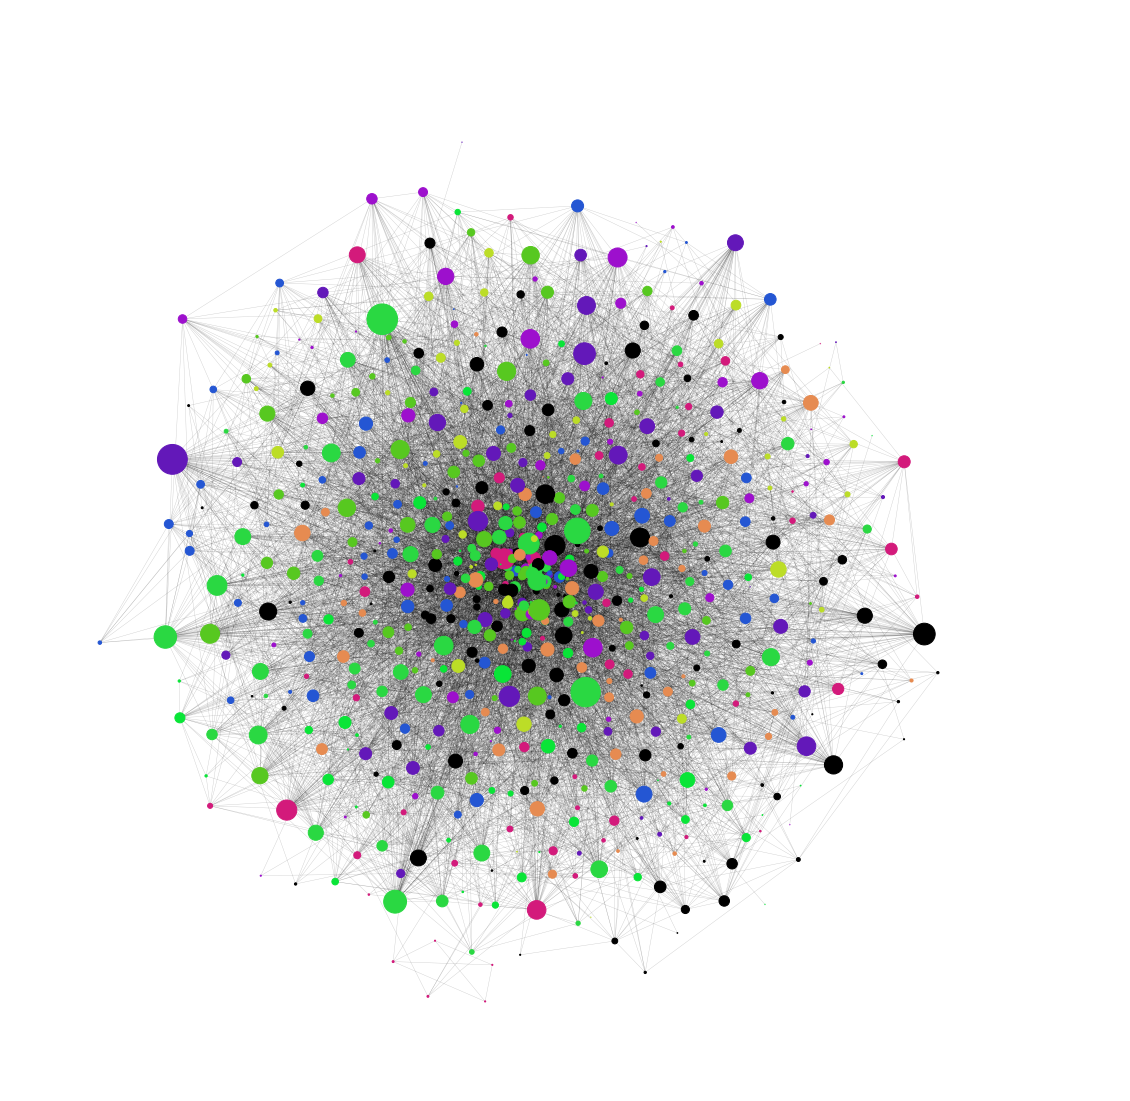

In [ ]:
plt.figure(figsize=(20,20))

options = {
  "node_size": node_sizes
}
nx.draw_networkx_nodes(H_movies, positions, **options, node_color=node_colors)

options = {
  "width": 0.4,
  "alpha": 0.2
}
nx.draw_networkx_edges(H_movies, positions, **options)
plt.axis('off')
plt.show()

Above is a visualization of the Movie network. Node sizes are based on their degree and node color is based on the community. Only communities larger than 50 are assigned a color, the remainder are black.

#### Actor Visualization

In [ ]:
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=False,  # Dissuade hubs
    edgeWeightInfluence=1.5,

    # Performance
    jitterTolerance=0.1,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1,

    # Tuning
    scalingRatio=0.005,
    strongGravityMode=False,
    gravity=20,

    # Log
    verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_actors, pos=None, iterations=200)

100%|██████████| 200/200 [00:06<00:00, 28.84it/s]

BarnesHut Approximation  took  2.92  seconds
Repulsion forces  took  3.47  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.11  seconds


In [ ]:
d = dict(G_actors.degree)
node_sizes = [(v * v)*0.15 for v in d.values()]

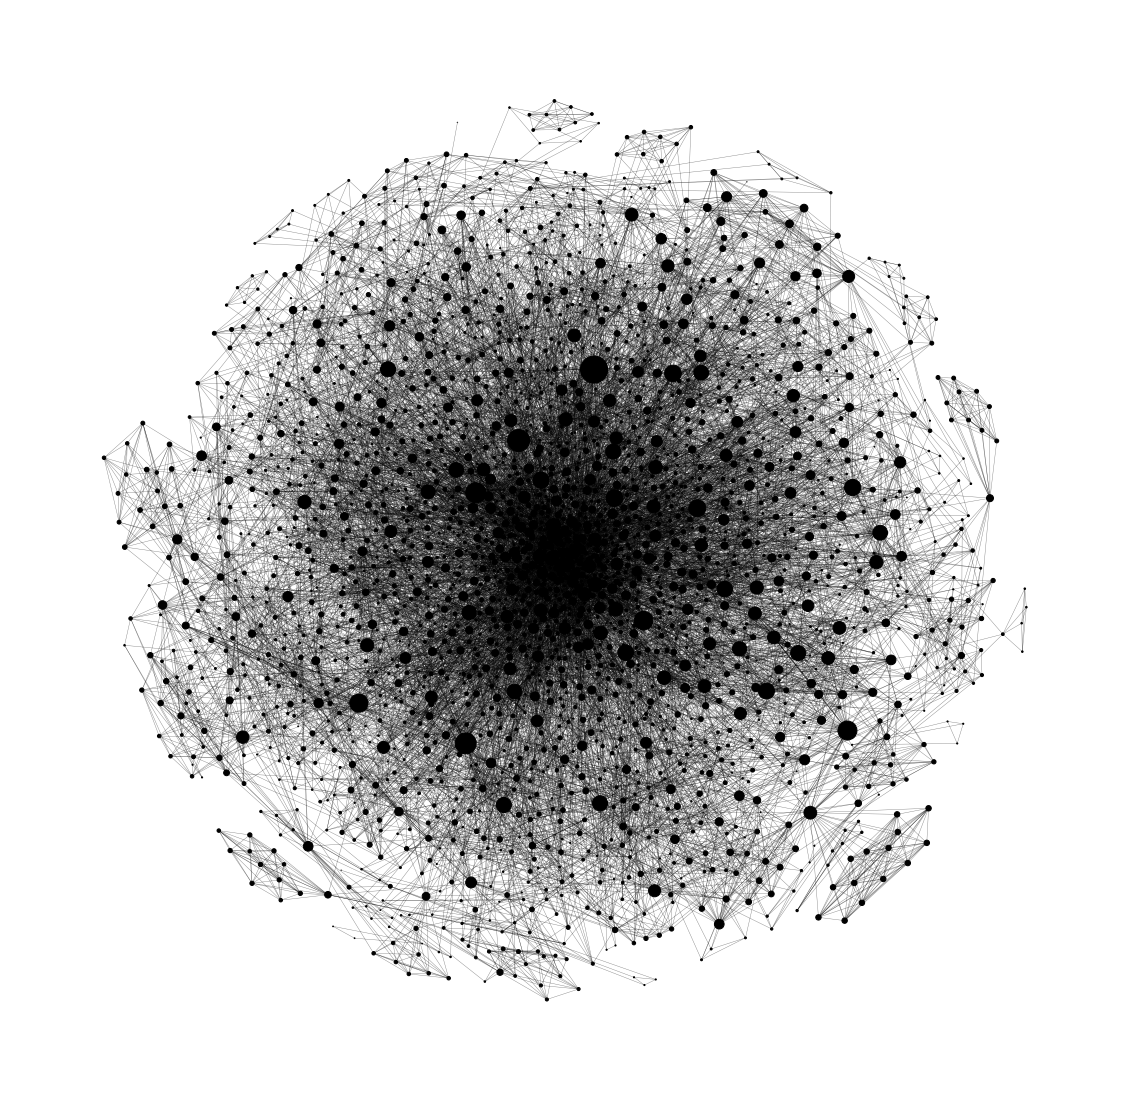

In [ ]:
plt.figure(figsize=(20,20))

options = {
  "node_size": node_sizes
}
nx.draw_networkx_nodes(G_actors, positions, **options, node_color="black")

options = {
  "width": 0.4,
  "alpha": 0.5
}
nx.draw_networkx_edges(G_actors, positions, **options)
plt.axis('off')
plt.show()

Above is a visualization of the Actor network, where node sizes are based on their degree. Based on how the network is build, we know that the connected components you can see along the edge are movies, as all actors in a film will get a connected to each other. Even more interesting is the observation of connected components that are not connected to anything else. These components represent films where actors have not appeared in any other top box office film.


## Step 3: Text Analysis

### Genre TF & TF-IDF

By analyzing movie plots per genre, we are interested in seeing whether genres share any words, as well as what words make a genre unique. To do that we calculate the top **frequent** words in each genre (TF value) but also the top **relevant** words in each genre (TF-IDF value). 

In [ ]:
# Read from csv
df_genres = pd.read_csv("tokens_per_genre.csv")

# Convert csv string values to lists
token_lists = []
unique_token_lists = []

for index, row in df_genres.iterrows():
    tokens = RegexpTokenizer(r'\w+').tokenize(row.Tokens)
    # remove one-letter and two-letter words
    tokens = [token for token in tokens if len(token) > 2]
    
    token_lists.append(tokens)
    
    # remove duplicates
    unique_tokens = sorted(set(tokens))
    unique_token_lists.append(unique_tokens)
            
df_genres['Tokens'] = token_lists
df_genres['Unique_Tokens'] = unique_token_lists
df_genres = df_genres.iloc[: , 1:]

In [ ]:
def get_tc(text, term):
    return text.count(term)

In [ ]:
def get_tf(tokens, term):
    num_terms = len(row.Tokens)
    return row.Tokens.count(term) / num_terms

In [ ]:
def get_tf_idf(tf, idf):
    return tf * idf

In [ ]:
def get_idf(num_docs, docs_containing_word):
    return np.log(num_docs/(1 + docs_containing_word))

In [ ]:
def get_tc_idf(tc, idf):
    return tc * idf

In [ ]:
def get_tf_idf(tf, idf):
    return tf * idf

In [ ]:
def get_idf_values(df):  
    # merge all genre unique tokens 
    all_unique_tokens = sorted(set(np.concatenate(df.Unique_Tokens)))
    idf_values = {}

    # before calculating the idf value of a term we also need to find the number of documents(movies) the term is included in
    for term in all_unique_tokens:
    
        docs_containing_word = 0

        # search in each genre's tokens for the term
        for index, doc in df.iterrows():
            if term in doc.Tokens:
                docs_containing_word += 1
        
        # calculate idf
        idf_values[term] = get_idf(len(df.index), docs_containing_word)
        
    return idf_values

In [ ]:
# WARNING: 15 minute runtime on this cell
# calculate idf values
idf_values = get_idf_values(df_genres)
# add idf values to dataframe
idf_dicts = []
for index, row in df_genres.iterrows():
    idf_dict = {term:idf_values[term] for term in row.Unique_Tokens}
    idf_dict = dict( sorted(idf_dict.items(), key=operator.itemgetter(1),reverse=True))
    
    idf_dicts.append(idf_dict)

df_genres['IDFs'] = idf_dicts

In [ ]:
tf_dicts = []
top_10_tfs = []

# calculate TF values, add top 10 to dataframe
for index, row in df_genres.iterrows():
    
    num_terms = len(row.Tokens)
    # get all tf values - create a dictionary
    tf_dict = {term:get_tf(row.Tokens, term) for term in row.Unique_Tokens}
    tf_dict = dict( sorted(tf_dict.items(), key=operator.itemgetter(1),reverse=True))
    top_10_tf = dict(itertools.islice(tf_dict.items(), 10))

    tf_dicts.append(tf_dict)
    top_10_tfs.append(list(top_10_tf.keys()))

df_genres['Top_10_TF'] = top_10_tfs
df_genres['TFs'] = tf_dicts

In [ ]:
tf_idf_dicts = []
top_10_tf_idfs = []

# calculate TF_IDF values, add top 10 to dataframe
for index, row in df_genres.iterrows():
    tf_idf_dict = {term:get_tf_idf(row.TFs[term], row.IDFs[term]) for term in row.Unique_Tokens}
    tf_idf_dict = dict( sorted(tf_idf_dict.items(), key=operator.itemgetter(1),reverse=True))
    top_10_tf_idf = dict(itertools.islice(tf_idf_dict.items(), 10))
    
    tf_idf_dicts.append(tf_idf_dict)
    top_10_tf_idfs.append(list(top_10_tf_idf.keys()))
    
df_genres['TF_IDF'] = tf_idf_dicts
df_genres['Top_10_TF_IDF'] = top_10_tf_idfs

In [ ]:
print("Top 10 words according to TF:")
for index, row in df_genres.iterrows():
    print("Genre ", row.Genre, ":", row.Top_10_TF)

print("\nTop 10 words according to TF_IDF:")
for index, row in df_genres.iterrows():
    print("Genre ", row.Genre, ":", row.Top_10_TF_IDF)

Top 10 words according to TF:
Genre  Sci-Fi : ['kill', 'use', 'find', 'take', 'escape', 'attack', 'leave', 'earth', 'help', 'one']
Genre  Horror : ['kill', 'find', 'house', 'take', 'leave', 'attack', 'michael', 'escape', 'father', 'one']
Genre  Music : ['crew', 'band', 'jimmy', 'elgin', 'show', 'battle', 'miguel', 'sara', 'david', 'freddie']
Genre  Mystery : ['find', 'kill', 'harry', 'take', 'leave', 'house', 'one', 'death', 'tell', 'return']
Genre  Sport : ['team', 'ricky', 'race', 'dre', 'game', 'mcqueen', 'win', 'joe', 'car', 'play']
Genre  War : ['kill', 'john', 'german', 'force', 'kyle', 'attack', 'diana', 'norman', 'soldier', 'japanese']
Genre  Comedy : ['take', 'find', 'leave', 'get', 'return', 'tell', 'new', 'back', 'help', 'make']
Genre  Romance : ['leave', 'tell', 'take', 'find', 'get', 'bella', 'love', 'return', 'back', 'new']
Genre  Musical : ['simba', 'elsa', 'take', 'anna', 'ella', 'mufasa', 'giselle', 'pride', 'emmet', 'rapunzel']
Genre  Fantasy : ['kill', 'find', 'retur

As we can see there is a significant difference between TF and TF-IDF values. TF (term frequency) gives us words that are often used in a document. In our dataset, for example, we can see that words like **"kill, find, leave, attack, help, return"** are appearing very often. This makes sense, since these are verbs that can generally describe a plot. However, these words are not very descriptive of the genres.

The IDF (inverse document frequency) of a word gives us the measure of how significant that term is between all genres because it takes into account the number of genres containing a term. Therefore, it mainly returns protagonist names like **"katniss, voldemort, shrek, zuckerberg, gandalf"** which help us get a better sense of a genre's movies. 

Ideally, when using TF-IDF, we would want to get words that describe a genre more accurately, without seeing character names. Since we were unable to remove these names for more than 700 movies, they now dominate the dataset's top words.


### Genre WorkClouds
Another way to see whether genres share any words and which words stand out throughout our dataset is by creating a WordCloud for each genre.

In [ ]:
tc_idf_dicts = []
for index, row in df_genres.iterrows():
    # calculate tc-idf values
    tc_idf_dict = {term:get_tc_idf(get_tc(row.Tokens, term), row.IDFs[term]) for term in row.Unique_Tokens}
    tc_idf_dicts.append(tc_idf_dict)
    
# add tc-idf values to dataframe
df_genres['TC_IDF'] = tc_idf_dicts

In [ ]:
wordcloud_strings = []
for index, row in df_genres.iterrows():
    
    wordcloud_string = ''
    for term in row.Unique_Tokens:
        # calculate how many times a term will be repeated in the string
        repeater = int(round(row.TC_IDF[term])) # TC_IDF is rounded up to the nearest integer value
        words = repeater * (term + ' ')
        wordcloud_string = wordcloud_string + words
    
    wordcloud_strings.append(wordcloud_string)

# add wordcloud strings to dataframe
df_genres['WordCloud_Text'] = wordcloud_strings

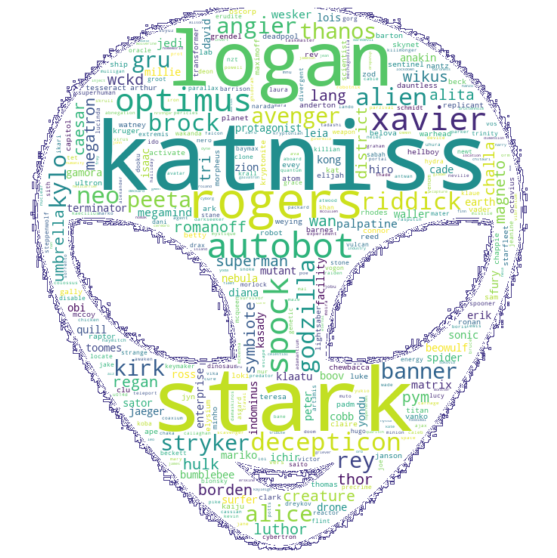

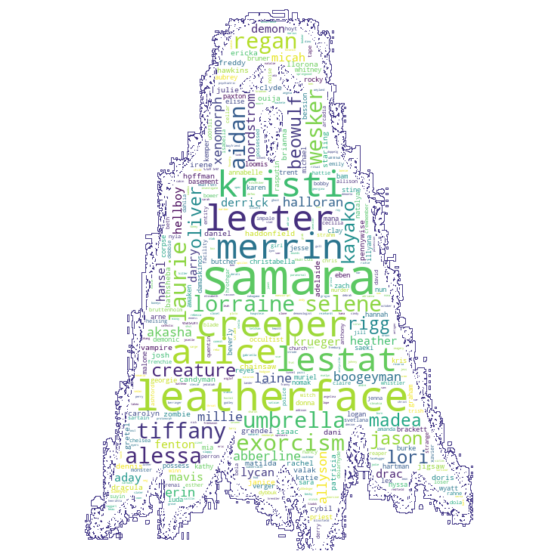

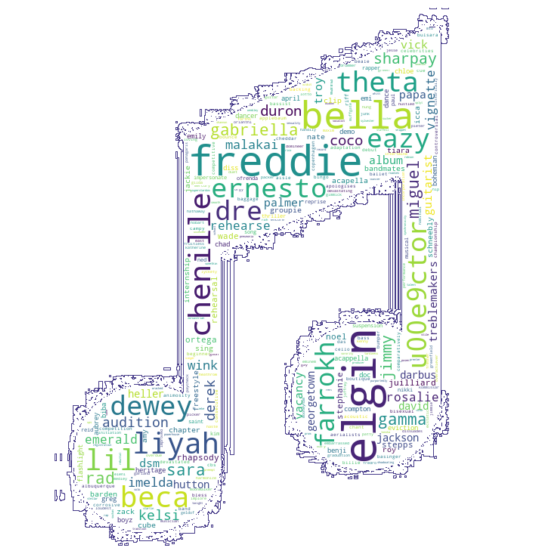

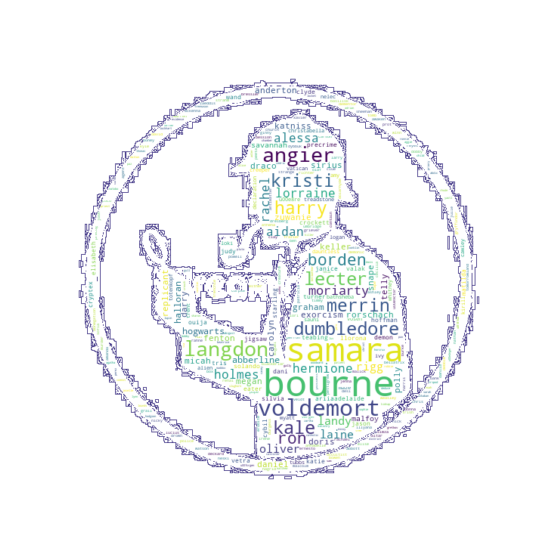

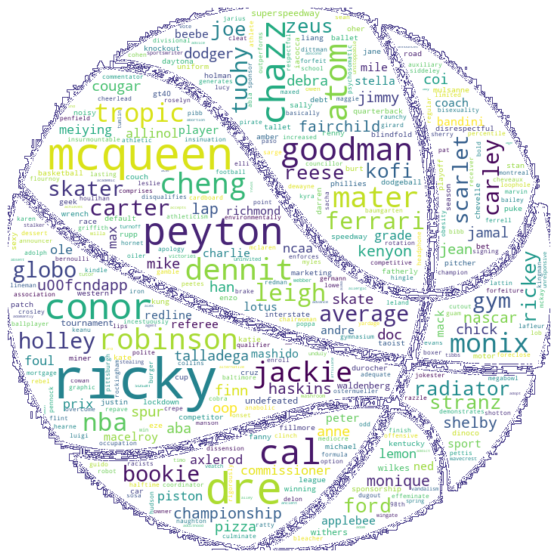

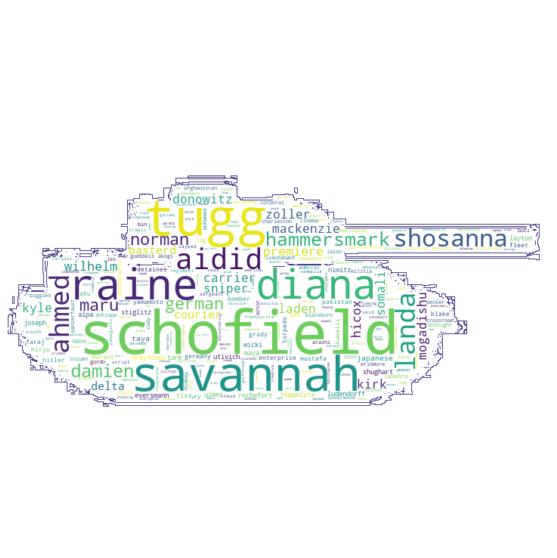

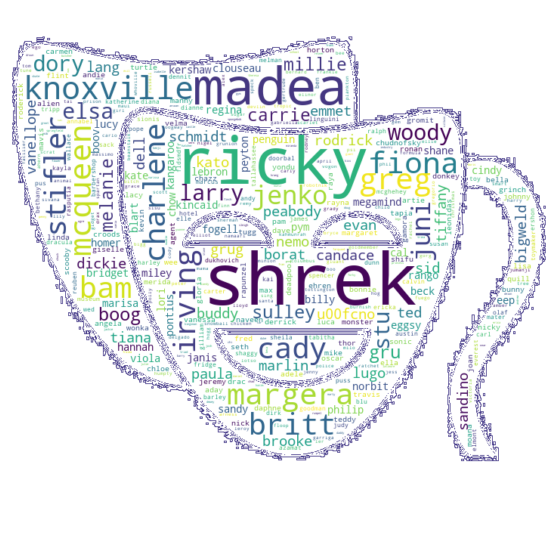

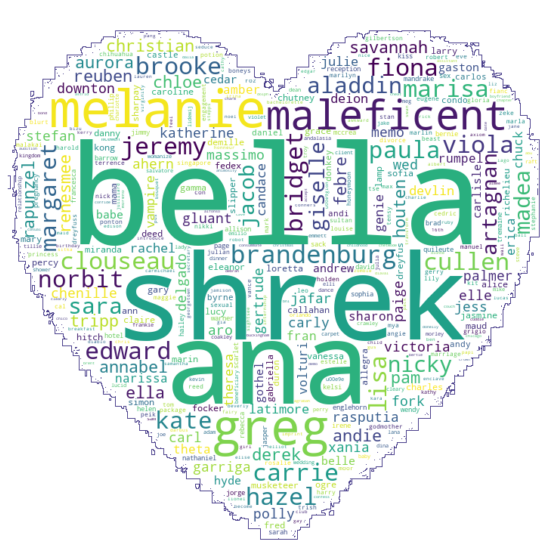

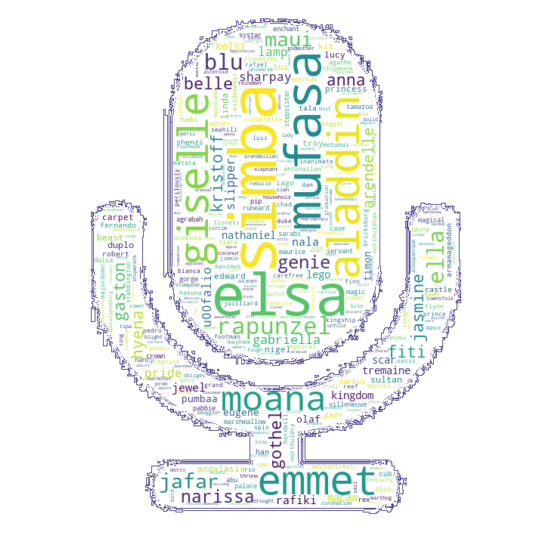

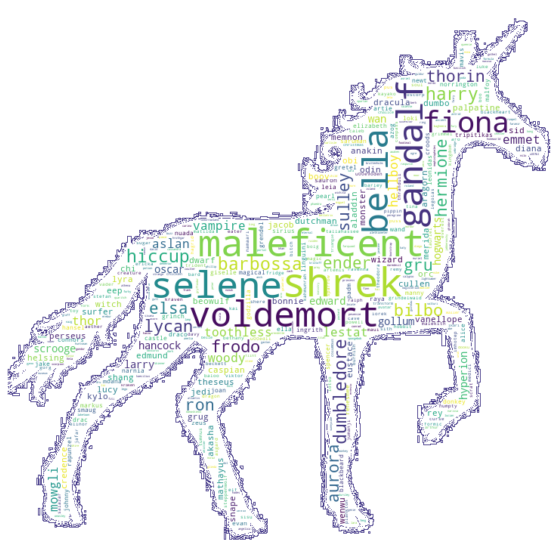

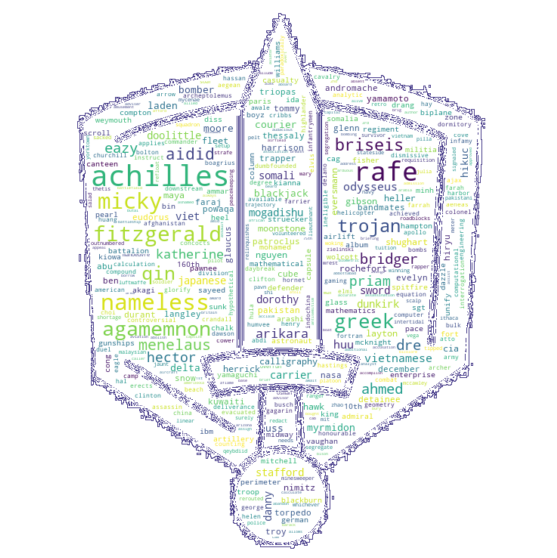

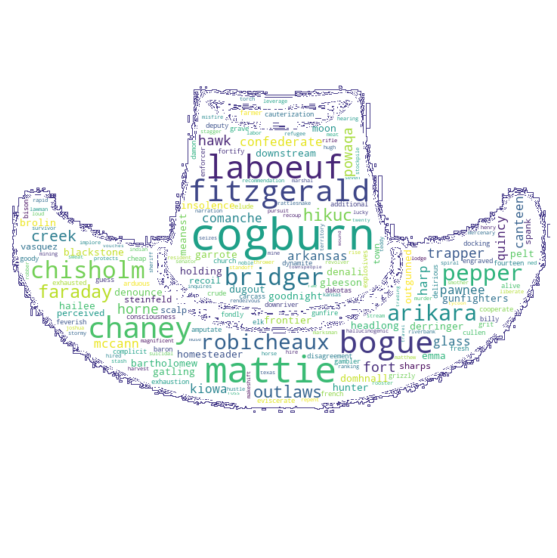

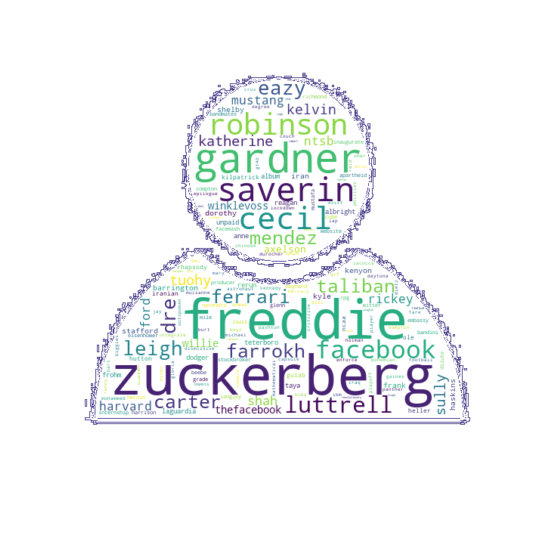

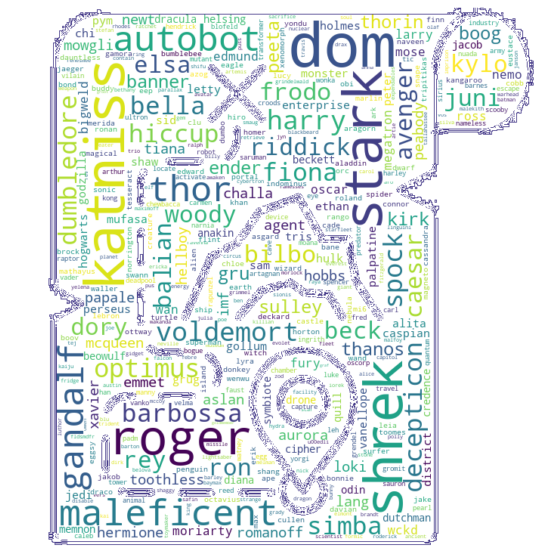

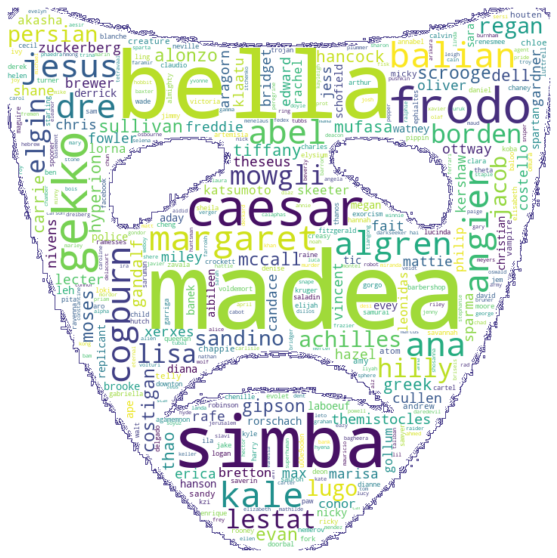

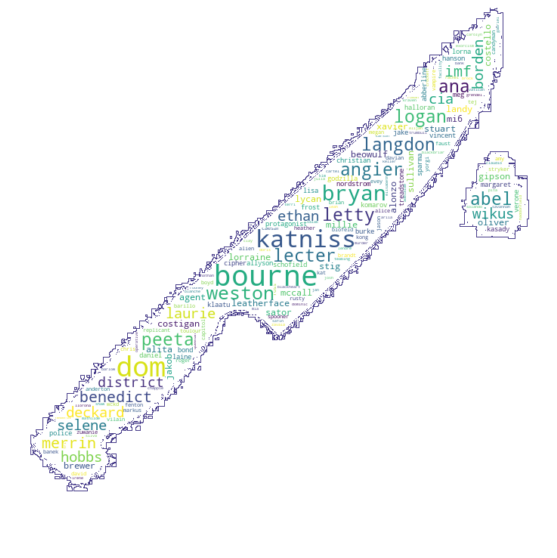

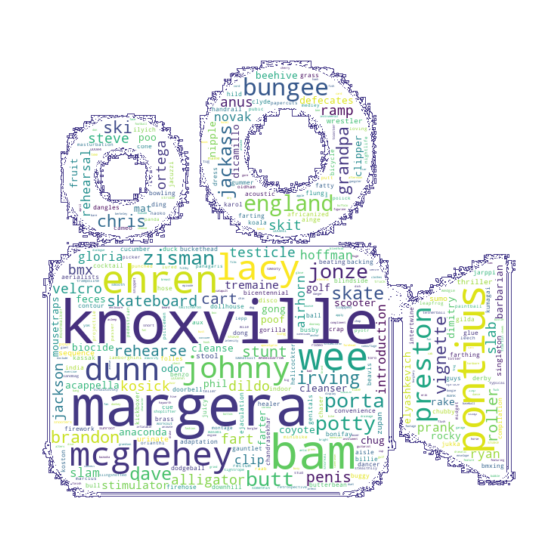

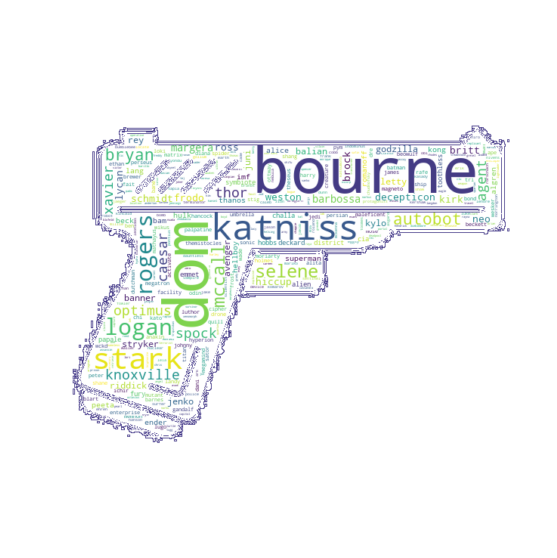

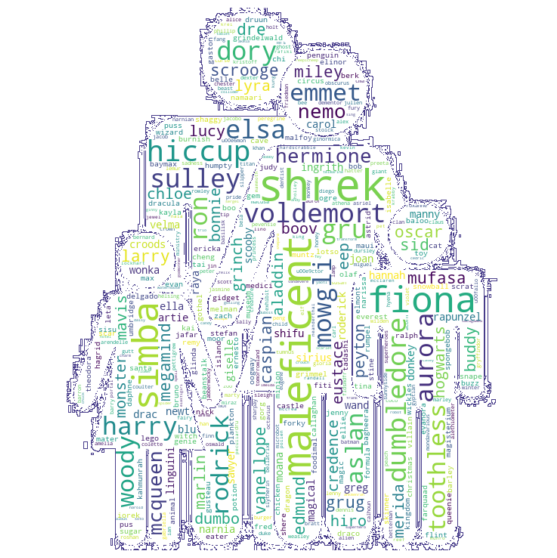

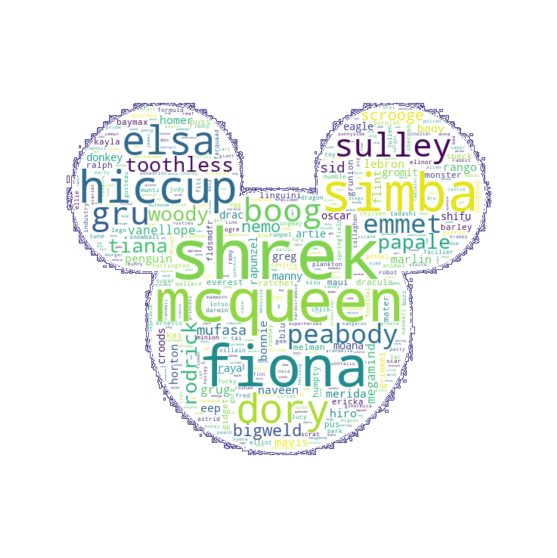

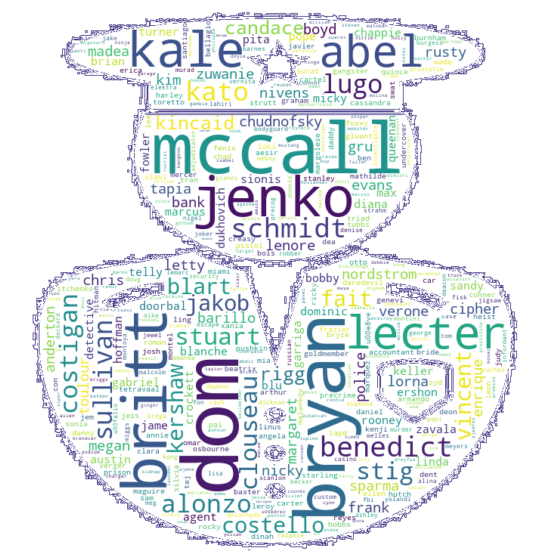

In [ ]:
for index, row in df_genres.iterrows():
    text = row.WordCloud_Text
    
    # Generate a word cloud image
    img = './genre_icons/' + row.Genre + '.jpg'

    mask = np.array(Image.open(img))
    wordcloud = WordCloud(background_color="white", max_words=400, mask=mask, contour_width=0.3, contour_color='DarkSlateBlue', collocations=False).generate(text)

    # Display the generated image:
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
    

**WordCloud generation for all movie genres**

From the generated wordclouds we can see that almost all genres are mostly described by the name of their characters, same way as before. Again, we would ideally want names to be filtered out so that we could comment on the language used in different genres. This wasn't practically feasible so we need to interperet the wordclouds differently. Instead of telling us about the general language used in a particular genre, the wordclouds tell us, through the character names, which film titles are the most popular in a genre and have become cult favorites. A few examples:

- **Shrek** has become a very popular movie and has attained a cultural status. This can be seen from our worldclouds, since Shrek is one of the top words in genres *Romance, Family, Animation, Fantasy*

- **Katniss** is also a very prevelant character name throughout our wordclouds. This also makes sense, since Katniss is the protagonist of the *Hunger Games* series which consists of four movies and had a large fanbase.

- Same goes for **Bella** and **Edward**, the main characters of the *Twilight series* but also **Stark, Thor, Logan** from the *Avenges* and **Frodo, Gandalf** from *The Lord of the Rings*. It seems movie series have a great influence over our wordclouds.

- Since **Jackass** is the only movie in the *Documentary* category we get a wordcloud only from its own plot. This is why we have more non-character words in this wordcloud.


## Step 4: Communities Analysis
Using the Louvain Algorithm, we have already extracted **movie communities**, so let's analyse them a bit further.

**Community Modularity**

In [ ]:
print("Modularity = ", community_louvain.modularity(partition, H_movies))

Modularity =  0.3873642471882176


**Community Size Distribution**

In [ ]:
# Create dictionary where (key,value) = (community_num, community_size)
community_sizes = {}
for k in sorted(communities, key=lambda k: len(communities[k]), reverse=True):
    community_sizes[k] = len(communities[k])

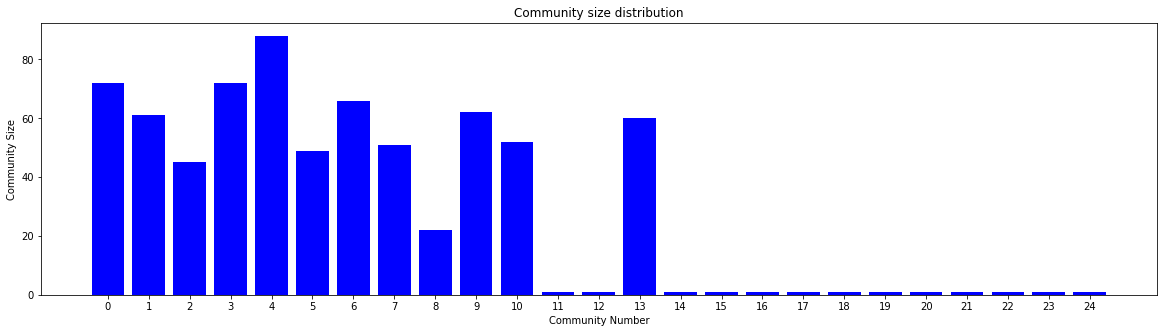

In [ ]:
plt.figure(figsize=(20,5))
plt.bar(community_sizes.keys(), community_sizes.values(), color='b')
plt.xticks(list(community_sizes.keys()))
plt.xlabel("Community Number")
plt.ylabel("Community Size")
plt.title("Community size distribution")
plt.show()

**Which are the top 3 movies of each community based on their degree distribution?**

In [ ]:
community_names = {}
for com in communities:
    temp_degree_dict = {}
    for character in communities[com]:
        temp_degree_dict[character] = H_movies.degree[character]
    community_names[com] = sorted(temp_degree_dict, key=temp_degree_dict.get, reverse=True)[:3]

In [ ]:
for key, value in community_names.items():
  print("Community", key, ":", value) 


Community 4 : ['Avengers: Age of Ultron', 'Avengers: Endgame', 'Avengers: Infinity War']
Community 13 : ['G-Force', "Valentine's Day", "New Year's Eve"]
Community 5 : ['The Lord of the Rings: The Return of the King', 'The Lord of the Rings: The Two Towers', 'The Lord of the Rings: The Fellowship of the Ring']
Community 6 : ['The Other Guys', 'Fast & Furious 6', 'Furious 7']
Community 10 : ['Safe House', 'American Gangster', '2 Guns']
Community 7 : ['Horton Hears a Who!', 'Midway', 'The Hunger Games: Mockingjay – Part 1']
Community 0 : ['Batman v Superman: Dawn of Justice', 'Ant-Man and the Wasp', 'Pearl Harbor']
Community 2 : ['Ride Along', "Fool's Gold", 'Scary Movie 4']
Community 3 : ['The Lego Movie', 'Batman Begins', 'Harry Potter and the Goblet of Fire']
Community 9 : ['Tropic Thunder', 'Night at the Museum: Battle of the Smithsonian', "Madagascar 3: Europe's Most Wanted"]
Community 1 : ['The Departed', 'Contagion', 'The Martian']
Community 8 : ['Shark Tale', 'Suicide Squad', 'Men

**Which are the 5 largest communities?**

In [ ]:
# Create a dictionary of the 5 largest communities
largest_communities = {}
for (key, value) in communities.items():
    if key in list(community_sizes)[:5]:
        largest_communities[key] = value

In [ ]:
print("Top 5 movie communities:\n")
for key, value in largest_communities.items():
  print("Community", key, ":", value) 

Top 5 movie communities:

Community 4 : ['10,000 BC', '42', 'A.I. Artificial Intelligence', 'Angels & Demons', 'Ant-Man', 'Avengers: Age of Ultron', 'Avengers: Endgame', 'Avengers: Infinity War', 'Birds of Prey', 'Black Panther', 'Black Widow', 'Blade Runner 2049', 'Captain America: Civil War', 'Captain America: The Winter Soldier', 'Captain Marvel', 'Changing Lanes', 'Chappie', 'Coach Carter', 'Crazy Rich Asians', 'Dune', 'End of Watch', "Ender's Game", 'Exodus: Gods and Kings', 'Exorcist: The Beginning', 'Fantastic Four', 'Glass', 'Halloween', 'Halloween Kills', 'Heartbreakers', "Hitman's Wife's Bodyguard", 'Hostel', 'Identity Thief', 'Incredibles 2', 'Iron Man', 'Iron Man 2', 'Iron Man 3', 'Jumper', 'Just like Heaven', 'Kong: Skull Island', 'Lakeview Terrace', 'Logan', "Miss Peregrine's Home for Peculiar Children", 'No Good Deed', 'Obsessed', 'Pacific Rim: Uprising', 'Prisoners', 'Prom Night', 'Raya and the Last Dragon', 'Real Steel', 'Rogue One: A Star Wars Story', 'S.W.A.T.', 'Sha

Each time the Louvain Algorithm runs, it returns a different community partition. However, throughout executions it was interesting seeing that the communities formed included movies from the same series or similar genres. This makes sense, since our network is build based on movies that share actors and it is probable that actors will continue playing in movie sequels or will be cast to play in the same genre.

For example:

-  *Community 1* includes action movies like **Fast and the Furious, The Expendables, Transformers**
-  *Community 2* includes animation movies like **Kung Fu Panda, Cars, Despicable Me** 
-  *Community 3* includes fantasy movies like **Harry Potter and Pirates of the Carribean**
-  *Community 4* includes fantasy, adventure movies like **Lord of the Rings and Star Wars**
-  *Community 5* includes superheroe movie series like **Avengers, Captain America, Iron Man, Spider Man**

**Do larger communities make a bigger box office hit?**

In [ ]:
# sum movie box office values for each community
box_office_sums = {}
for index, values in communities.items():
    # print(index, values)
    box_office_sum = 0
    for title in values:
        try:
          box_office_sum = box_office_sum + df.loc[df['title'] == title].box_office.values[0]
        except Exception as e: 
          print(e)
          print('No box office found for:', title)
    
    # normalize values
    box_office_sums[index] = box_office_sum/ len(values)

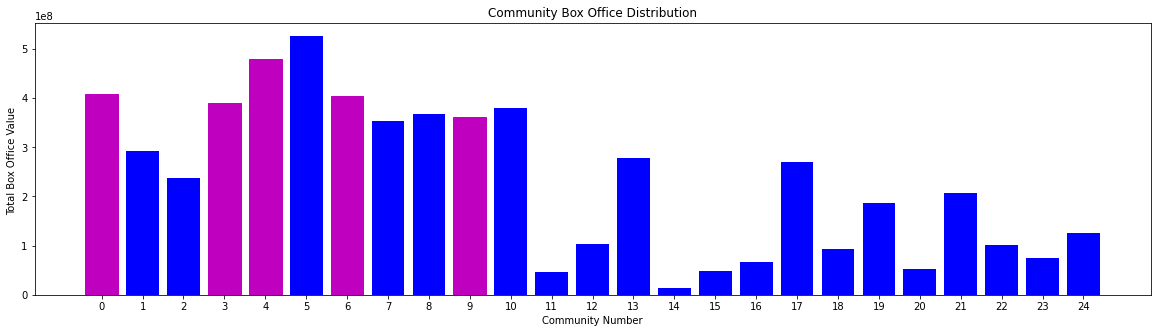

In [ ]:
plt.figure(figsize=(20,5))
barlist = plt.bar(box_office_sums.keys(), box_office_sums.values(), color='b')
for index in largest_communities:
    bar_index = list(communities.keys()).index(index)
    barlist[bar_index].set_color('m')


plt.xticks(list(community_sizes.keys()))
plt.xlabel("Community Number")
plt.ylabel("Total Box Office Value ")
plt.title("Community Box Office Distribution")
plt.show()


From the *Community Box Office Distribution* plot we can see that the top 5 largest communities (magenta bars) are also getting a quite high box office revenue. This indicates that larger communities tend to have more popular and thus more profitable movies. Considering the largest communities include a lot of famous movie series this is reasonable. 

**Community Text Analysis**

In [ ]:
# Convert csv string values to lists
token_lists = []
unique_token_lists = []

for index, row in df.iterrows():
    tokens = RegexpTokenizer(r'\w+').tokenize(row.Tokens)
    token_lists.append(tokens)
    
    unique_tokens = RegexpTokenizer(r'\w+').tokenize(row.Unique_Tokens)
    unique_token_lists.append(unique_tokens)

df['Tokens'] = token_lists
df['Unique_Tokens'] = unique_token_lists

In [ ]:
# create dataframe for communities and their tokens
df_communities = pd.DataFrame({'Community': largest_communities.keys()}) 

token_lists = []

for key, value in largest_communities.items():
    community_tokens = []
    for movie in value:
        movie_tokens = df.loc[df['title'] == movie].Tokens.tolist()
        movie_tokens_flat = [item for sublist in movie_tokens for item in sublist]
        
        community_tokens = community_tokens + movie_tokens_flat
    
    token_lists.append(community_tokens)

df_communities['Tokens'] = token_lists

In [ ]:
# add Unique_Tokens column to dataframe
unique_token_lists = []

for index, row in df_communities.iterrows():
    unique_token_lists.append(unique_tokens)

df_communities['Unique_Tokens'] = unique_token_lists

In [ ]:
# calculate idf values 
idf_values = get_idf_values(df_communities)

In [ ]:
# add idf values to dataframe
idf_dicts = []

for index, row in df_communities.iterrows():
    idf_dict = {term:idf_values[term] for term in row.Unique_Tokens}
    idf_dict = dict( sorted(idf_dict.items(), key=operator.itemgetter(1),reverse=True))
    
    idf_dicts.append(idf_dict)

df_communities['IDFs'] = idf_dicts

In [ ]:
tf_dicts = []
top_10_tfs = []

# calculate TF values, add top 1- to dataframe
for index, row in df_communities.iterrows():
    # get all tf values - create a dictionary
    tf_dict = {term:get_tf(row.Tokens, term) for term in row.Unique_Tokens}
    tf_dict = dict( sorted(tf_dict.items(), key=operator.itemgetter(1),reverse=True))
    top_10_tf = dict(itertools.islice(tf_dict.items(), 10))

    tf_dicts.append(tf_dict)
    top_10_tfs.append(list(top_10_tf.keys()))

df_communities['Top_10_TF'] = top_10_tfs
df_communities['TFs'] = tf_dicts

In [ ]:
tf_idf_dicts = []
top_10_tf_idfs = []

# calculate TF_IDF values, add top 10 to dataframe
for index, row in df_communities.iterrows():
    tf_idf_dict = {term:get_tf_idf(row.TFs[term], row.IDFs[term]) for term in row.Unique_Tokens}
    tf_idf_dict = dict( sorted(tf_idf_dict.items(), key=operator.itemgetter(1),reverse=True))
    top_10_tf_idf = dict(itertools.islice(tf_idf_dict.items(), 10))
    
    tf_idf_dicts.append(tf_idf_dict)
    top_10_tf_idfs.append(list(top_10_tf_idf.keys()))
    
df_communities['TF_IDF'] = tf_idf_dicts
df_communities['Top_10_TF_IDF'] = top_10_tf_idfs

In [ ]:
print("\nTop 10 words according to TF:")
for index, row in df_communities.iterrows():
    print("Community ", row.Community, ":", row.Top_10_TF)

print("\nTop 10 words according to TF_IDF:")
for index, row in df_communities.iterrows():
    print("Community ", row.Community, ":", row.Top_10_TF_IDF)


Top 10 words according to TF:
Community  4 : ['find', 'leave', 'use', 'escape', 'return', 'help', 'power', 'back', 'lead', 'home']
Community  6 : ['find', 'escape', 'use', 'leave', 'return', 'back', 'get', 'help', 'make', 'lead']
Community  0 : ['find', 'use', 'leave', 'return', 'escape', 'back', 'make', 'help', 'get', 'father']
Community  3 : ['find', 'escape', 'father', 'return', 'use', 'leave', 'two', 'die', 'family', 'back']
Community  9 : ['find', 'leave', 'return', 'back', 'family', 'help', 'get', 'make', 'escape', 'use']

Top 10 words according to TF_IDF:
Community  4 : ['dolores', 'diminish', 'alma', 'ostracize', 'loses', 'sadness', 'sentient', 'told', 'crack', 'fulfil']
Community  6 : ['bruno', 'fault', 'prediction', 'burden', 'youngest', 'crack', 'deaf', 'abuela', 'alma', 'antonio']
Community  0 : ['pedro', 'precognition', 'fault', 'phenomenon', 'told', 'incoming', 'burden', 'diminish', 'antonio', 'deaf']
Community  3 : ['dolores', 'phenomenon', 'candle', 'ears', 'antonio', 

**Do communities of movies share any words? Are there any words that distinguish each community?**

When looking through the top words for communities according to their TF value we can see that all communities share words like **'find, leave, escape, return'**. These are verbs that can generally describe a story, thus it makes sense that they all share them.

From the TF-IDF top words, however, we cannot really see any pattern emerge, that could differentiate communities between them. We can again see many names like **bruno, antonio, dolores, isabela** which are not helpful in getting a clear view of a community's characteristics. It is also noteworthy, that a lot of the communities share TF-IDF names. This could mean, that movies from the same movie series (and thus with the same characters) ended up in different communities.

## Step 5: Sentiment Analysis

In [ ]:
#Function to clean the movie plot description.

def mr_clean(text):
    #stopwords = nltk.corpus.stopwords.words('english')
    stemmer = nltk.WordNetLemmatizer()
    known_problematic_characters = ['\n', '\\']

    for chara in known_problematic_characters:
        try:
            text = text.replace(chara,"")
        except:
            pass

    #text = stemmer.lemmatize(text)
        
    return text

In [ ]:
#We load the Vader lexicon.
nltk.download('vader_lexicon')
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
     |████████████████████████████████| 125 kB 4.2 MB/s 


In [ ]:
#Here we get the Vader sentiment analysis scores for every movie.

compound_list = []
neutral_list = []
positive_list = []
negative_list = []
smth_wrong = []
for movie in list(df.title):
    plot = df.loc[df['title'] == movie].Plot.values[0]
    clean_plot = mr_clean(plot)
    try:
        scores = analyzer.polarity_scores(clean_plot)
        compound_list.append((scores['compound']))
        neutral_list.append((scores['neu']))
        positive_list.append((scores['pos']))
        negative_list.append((scores['neg']))
    except Exception as e:
        print(e)
        smth_wrong.append(movie)
        compound_list.append(sum(compound_list) / len(compound_list))
        neutral_list.append(sum(neutral_list) / len(neutral_list))
        positive_list.append(sum(positive_list) / len(positive_list))
        negative_list.append(sum(negative_list) / len(negative_list))


In [ ]:
#We add these lists of sentiment values to the dataframe.
len(smth_wrong)
df['compound'] = compound_list
df['neutral'] = neutral_list
df['positive'] = positive_list
df['negative'] = negative_list

In [ ]:
#We define the list of box office groups, so we can get a nice ordering.

box_office_groups = ['very low box office','low box office','medium box office','high box office','very high box office']

In [ ]:
#Creating the subplot for negative scores for different box office groups.

fig = make_subplots(rows=5, cols=1, shared_xaxes=True,)

for i,group in enumerate(box_office_groups):
    j=1

    temp_df = df[df.bo_groups == group]

    data = np.array(list(temp_df['negative'].values))
    hist, bins = np.histogram(data, bins=30)
    fig.add_trace(go.Bar(x=bins[:-1], y=hist,name=group),i+1,j)

fig.update_xaxes(title_text="Negativity score", row = 5, col = 1)
fig.update_yaxes(title_text="Frequency", row = 3, col = 1)
fig.update_layout(title_text="Movie plot negativity scores for different box offices")
fig.show()

It's seems that there's no pattern appearing here. Perhaps the very high box office movies have a slighly higher negative rating.

In [ ]:
#Creating the subplot for positive scores for different box office groups.

fig = make_subplots(rows=5, cols=1, shared_xaxes=True)

for i,group in enumerate(box_office_groups):
    j=1

    temp_df = df[df.bo_groups == group]

    data = np.array(list(temp_df['positive'].values))
    hist, bins = np.histogram(data, bins=30)
    fig.add_trace(go.Bar(x=bins[:-1], y=hist,name=group),i+1,j)

fig.update_xaxes(title_text="Positivity score", row = 5, col = 1)
fig.update_yaxes(title_text="Frequency", row = 3, col = 1)
fig.update_layout(title_text="Movie plot positivity scores for different box offices")
fig.show()

In the above graphs there's also no obvious pattern. It seems that the higher the box office the more the higher positive score it has. But this is barely noticable.

In [ ]:
#A plot to showcase the compound scores for al of the movies

fig = go.Figure()

data = np.array(list(df['compound'].values))
hist, bins = np.histogram(data, bins=30)
fig.add_trace(go.Bar(x=bins[:-1], y=hist))
fig.update_layout(title_text='Movie plot compound scores',xaxis_title="Compound scores",yaxis_title="Frequency")
fig.show()

Above we have the compound scores for all of the movies. It can be seen that the values are very extreme with the majority being around -1 and 1. A huge amount of the movies are at -1. 

In [ ]:
#Creating the subplot for neutrality scores for different box office groups.

fig = make_subplots(rows=5, cols=1, shared_xaxes=True)
x_axis = dict(title='Neutrality scores',y=0.1,x=0.5)    

for i,group in enumerate(box_office_groups):
    j=1

    temp_df = df[df.bo_groups == group]

    data = np.array(list(temp_df['neutral'].values))
    hist, bins = np.histogram(data, bins=30)
    fig.add_trace(go.Bar(x=bins[:-1], y=hist,name=group),i+1,j)
    

fig.update_xaxes(title_text="Neutrality score", row = 5, col = 1)
fig.update_yaxes(title_text="Frequency", row = 3, col = 1)
fig.update_layout(title_text="Movie plot neutrality scores for different box offices")
fig.show()

Here we have the neutrality scores for different box office groups. All of the groups have high neutrality scores and there's not much difference. It seems like the neutrality value is reducing the higher the box office value is.

In [ ]:
# We get all of the genres for later plotting

temp=list(set(df['genres'].values))

movie_genres = [value for sublist in temp for value in ast.literal_eval(sublist)]

movie_genres_set = list(set(movie_genres))

genre_list = []
for genre in movie_genres_set:
    genre_list.append(genre.replace(' ',''))

genre_list = np.sort(list(set(genre_list)))

In [ ]:
#Creating the subplot for negative scores for different genres.

fig = make_subplots(rows=10, cols=2, shared_xaxes=True, shared_yaxes=True)

for i,genre in enumerate(genre_list[:-1]):
    genre_values = []
    for index, row in df.iterrows():
        if str(genre) in row.genres:
            genre_values.append(row.negative)

    b = (i%2) +1
    a = (i//2) +1
    hist, bins = np.histogram(genre_values, bins=30)
    fig.add_trace(go.Bar(x=bins[:-1], y=hist,name=genre),a,b)

fig.update_xaxes(title_text="Negativity score", row = 10, col = 1)
fig.update_yaxes(title_text="Frequency", row = 4, col = 1)
fig.update_layout(title_text="Movie plot negativity scores for different genres")
fig.show()

In the plot above the negativity scores for different genres are shown. The values are quite similar. Perhaps mystery, sci-fi and thriller have slighly higher negativity scores than the rest. It also seems, that romance has lower negativity scores than the other genres and it's quite noticable.

In [ ]:
#Creating the subplot for positive scores for different genres.

fig = make_subplots(rows=10, cols=2, shared_xaxes=True, shared_yaxes=True)

for i,genre in enumerate(genre_list[:-1]):
    genre_values = []
    for index, row in df.iterrows():
        if str(genre) in row.genres:
            genre_values.append(row.positive)

    b = (i%2) +1
    a = (i//2) +1
    hist, bins = np.histogram(genre_values, bins=30)
    fig.add_trace(go.Bar(x=bins[:-1], y=hist,name=genre),a,b)

fig.update_xaxes(title_text="Positivity score", row = 10, col = 1)
fig.update_yaxes(title_text="Frequency", row = 4, col = 1)
fig.update_layout(title_text="Movie plot positivity scores for different genres")
fig.show()

The postivity values for the different genres has some more differences. It seems like mystery, sci-fi and thriller have lower positivity scores. It makes sense since they also had higher negativity scores. The logic is similar for romatinc films, which have higher positivity scores compared to the other genres. What also pops out here, is that horror movies have small positivity values (where as the negativity scores didn't stand out).

In [ ]:
#Creating the subplot for neutrality scores for different genres.


fig = make_subplots(rows=10, cols=2, shared_xaxes=True, shared_yaxes=True)

for i,genre in enumerate(genre_list[:-1]):
    genre_values = []
    for index, row in df.iterrows():
        if str(genre) in row.genres:
            genre_values.append(row.neutral)

    b = (i%2) +1
    a = (i//2) +1
    hist, bins = np.histogram(genre_values, bins=30)
    fig.add_trace(go.Bar(x=bins[:-1], y=hist,name=genre),a,b)

fig.update_xaxes(title_text="Neutrality score", row = 10, col = 1)
fig.update_yaxes(title_text="Frequency", row = 4, col = 1)
fig.update_layout(title_text="Movie plot neutrality scores for different genres")
fig.show()

Again, all of the movies have high values of neutrality, no matter the genre. It seems like there are no patterns or exceptions.

**Sentiment analysis summary**

First of all, the compound scores were very extreme (mostly -1 and many equal to 1) and the neutrality scores were high for all of the movies. This could indicate that the text was written in a very neutral manner. This would make sense since the text is from Wikipedia. This high level of neutrality might make it difficult for VADER to compute more diverse compound scores. We also saw that the scores of negativity or positivty were also relatively small. However, some tendencies were caught.

**Box office group analysis**

It seemed that the lower the box office value the bigger the neutrality values were. This could mean two things. Either, the lesser/less succesful movies were described in a more neutral manner or they actually have plots that are more neutral. On top of that, it seemed that the higher the box office value was the bigger negative and/or positive scores it had. It goes in line with the tendency of neutrality values. Higher box office movies could either be written about in a more emotional manner since it has more fans/critics. Or the movie itself has more emotion indicating things in the plot.

**Genre analysis**

Regarding genres, the neutrality scores were still relatively big and similar through out all genres. However, genres like mystery, sci-fi, thriller, horror and romance stood out. The first four showed higher negativity scores and lower positivity scores. This makes complete sense, it is hard to imagine a horror or mystery movie showcasing positivity. It carries the opposite purpose. It is similar for romantic movies. Even though romantic movies can have bitersweet moments or endings it usually has a fairly positive and uplifting storyline. These movies are for dreaming and this requires positivity.

# Discussion


#### Summary

First of all, let's summarize what we learned in our analysis! Our group set the objective of learning more about the movie industry. We've looked at the most succesful/profitable movies. We explored the data in search of patterns and other interesting findings. The techniques utilized for this were **network analysis** and **text analysis**. We were able to gain insight into influence of actors, influence of movies, casting diversity, factors leading to higher box office values, factors in movies related to their genre and more. We can say that no groundbreaking facts were discover, but the anlysis is interesting nonetheless.

## What went well?
   

Several things will be pointed out here:
* Data retrieval and processing. This part is hard in every project and we believe we handled it quite well. We gathered data from different sources and tried to keep it clean. Working with sources like Wikipedia can be tricky but we defintely managed to utilize it.
* Theory appliance. We managed to use many of the tools and techniques we observed in the course. Often looking for inspiration in our previous notebooks and course notes.
* Analysis visualisation/presentation. Even though this is not the primary requirement of the project we did a great job on this. The website presents our project in stylistic and clean manner.

##  What is still missing? What could be improved?

**Network Analysis**

The choice of our data obviously biased the analysis. The movies came from a list of top box office films for the weekends of years 2001-2021. This means we are exploring only a small segment of the industry. Including more movies of differnt types (different box office values, popularity, casting). This type of examination could bear more results and more interesting findings. On top of that, more attributes could included for the movies. We also didn't utilize the information we had on writers and directors. So that is definetely an option to explore.

**Text Analysis**

Through our analysis, we realized that character names dominated popular words and wordclouds. Ideally, by removing them, we could have gotten a clearer view of words that describe a movie genre. 
Another issue is that movies can belong to multiple genres. This means that genres ended up sharing a lot of words and it was difficult to find differences between them. Alternatively, we could have used only one genre per movie. 
Another option that could have helped us get more insight, would be to also use movie scripts along with our movie plots.

**Sentiment Analysis**

Increasing the amount of data here would greatly improve the quality of the investigation. The lack of data was noticable in analysis related to genres since we did not observe many War movies or musicals. Besides this, examining movie scripts (actual movie text) would be very interesting. Obviously, that part carries much more emotion in it than the movie plot descriptions on Wikipedia. The text on Wikipedia is written in a fairly neutral manner, which we saw in our results.

# Contibutions

* Data retrieval - Nicolai and Melina
* Data processing - Nicolai, Melina and Marius
* Basic stats - Nicolai
* Network analysis - Marius and Melina
* Network visualisation - Nicolai
* Wordclouds - Melina
* TF-IDF work - Melina
* Community detection - Melina
* Sentiment Analysis - Marius
* Website management - Nicolai and Melina